# 3 object

## func

In [5]:
# -*- coding: utf-8 -*-
"""
Three Object Grid - Spatial Reasoning in LLMs

This script investigates how language models understand and represent
spatial relationships between three objects in a 3D space.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import itertools
import random
import os
from collections import Counter

# -------------------------------
# Step 1: Load a Small LLaMA Model
# -------------------------------
def load_model(model_name="meta-llama/Llama-3.2-3B", token=None):
    """Load the language model with tokenizer."""
    print(f"Loading {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
    model = AutoModelForCausalLM.from_pretrained(model_name,
                                                output_hidden_states=True,
                                                token=token).cuda()
    model.eval()
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

# -------------------------------
# Step 2: Grid representation
# -------------------------------
# Define the grid size and objects
GRID_SIZE = (9, 9, 9)  # 3D grid size (z, y, x)
OBJECTS = {
    "chair": 1, "table": 2, "car": 3, "lamp": 4, "box": 5,
    "book": 6, "vase": 7, "plant": 8, "computer": 9, "phone": 10
}

# Define spatial relationships with displacement vectors (x, y, z)
d = 2  # Displacement magnitude
SPATIAL_MAP = {
    # horizontal (x)
    "left": (-d, 0, 0),
    "right": (d, 0, 0),

    # depth (y)
    "in_front": (0, d, 0),
    "front": (0, d, 0),
    "behind": (0, -d, 0),
    "back": (0, -d, 0),

    # vertical (z)
    "above": (0, 0, d),
    "below": (0, 0, -d),

    # diagonal
    "diagonally_front_left": (-d, d, 0),
    "diagonally_front_right": (d, d, 0),
    "diagonally_back_left": (-d, -d, 0),
    "diagonally_back_right": (d, -d, 0),

    # 3D combination
    "above_and_left": (-d, 0, d),
    "above_and_right": (d, 0, d),
    "below_and_left": (-d, 0, -d),
    "below_and_right": (d, 0, -d),
    "above_and_in_front": (0, d, d),
    "above_and_behind": (0, -d, d),
    "below_and_in_front": (0, d, -d),
    "below_and_behind": (0, -d, -d),
    "to_the_left_diagonally": (-d, d, 0),
    "to_the_right_diagonally": (d, d, 0),
    "left_front": (-d, d, 0),
    "right_front": (d, d, 0),
    "left_back": (-d, -d, 0),
    "right_back": (d, -d, 0)
}

# Categorize the relationships
RELATIONSHIP_CATEGORIES = {
    "vertical": ["above", "below", "above_and_in_front", "above_and_behind",
                "below_and_in_front", "below_and_behind"],
    "horizontal": ["left", "right", "above_and_left", "above_and_right",
                  "below_and_left", "below_and_right"],
    "depth": ["in_front", "front", "behind", "back"],
    "diagonal": ["diagonally_front_left", "diagonally_front_right",
                "diagonally_back_left", "diagonally_back_right",
                "to_the_left_diagonally", "to_the_right_diagonally",
                "left_front", "right_front", "left_back", "right_back",
                "diagonally_front_right", "diagonally_front_left",
                "diagonally_back_right", "diagonally_back_left",
                "left_diagonally", "right_diagonally"]
}

# Create reverse mapping for category lookup
RELATIONSHIP_TO_CATEGORY = {}
for category, relations in RELATIONSHIP_CATEGORIES.items():
    for relation in relations:
        RELATIONSHIP_TO_CATEGORY[relation] = category

# -------------------------------
# Step 3: Helper Functions for Parsing Relations
# -------------------------------
def normalize_relation(relation):
    """Normalize relation strings to standard format."""
    relation = relation.lower().strip()
    relation = relation.replace(" of", "").replace("to the ", "")

    # Standardize spacing and dashes
    relation = relation.replace("-", "_")
    relation = relation.replace(" ", "_")

    # Handle more diagonal relation variations
    if ("left" in relation and "diagonally" in relation and "front" in relation) or \
       ("left" in relation and "diagonal" in relation and "front" in relation):
        return "diagonally_front_left"
    elif ("right" in relation and "diagonally" in relation and "front" in relation) or \
         ("right" in relation and "diagonal" in relation and "front" in relation):
        return "diagonally_front_right"
    elif ("left" in relation and "diagonally" in relation and "back" in relation) or \
         ("left" in relation and "diagonal" in relation and "back" in relation):
        return "diagonally_back_left"
    elif ("right" in relation and "diagonally" in relation and "back" in relation) or \
         ("right" in relation and "diagonal" in relation and "back" in relation):
        return "diagonally_back_right"

    # Handle existing normalizations
    if relation in ["in_front_of", "front_of"]:
        relation = "in_front"
    elif relation in ["to_the_left", "to_left"]:
        relation = "left"
    elif relation in ["to_the_right", "to_right"]:
        relation = "right"

    # Handle compound relations
    if "and" in relation:
        parts = relation.split("and")
        parts = [p.strip('_') for p in parts]
        relation = f"{parts[0]}_and_{parts[1]}"

    return relation

def extract_relation_from_sentence(sentence):
    """Extract spatial relation from sentence."""
    # First try to match compound relations
    compound_pattern = r"is ((?:to the )?\w+(?:[ -]\w+)*) and ((?:to the )?\w+(?:[ -]\w+)*)(?: of)? the"
    compound_match = re.search(compound_pattern, sentence, re.IGNORECASE)

    if compound_match:
        rel1 = compound_match.group(1)
        rel2 = compound_match.group(2)
        return f"{rel1} and {rel2}"

    # Try more specific patterns for different formulations
    patterns = [
        r"is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the",
        r"is ((?:diagonally )?\w+(?:[- ]\w+)*)(?: of)? the",
        r"is ((?:in front )?\w+(?:[- ]\w+)*)(?: of)? the",
        r"is ((?:behind )?\w+(?:[- ]\w+)*)(?: of)? the",
        r"a (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the"
    ]

    for pattern in patterns:
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        if matches:
            if isinstance(matches[0], tuple):
                relation = matches[0][1] if len(matches[0]) > 1 else matches[0][0]
            else:
                relation = matches[0]
            return relation

    # Last resort - check for basic spatial terms
    spatial_terms = ["left", "right", "above", "below", "in front", "behind",
                     "front", "back", "diagonally"]

    for term in spatial_terms:
        if term in sentence.lower():
            return term

    return "unknown"

def determine_relationship_category(relation):
    """Map relation to its category index (0=vertical, 1=horizontal, 2=depth, 3=diagonal, 4=compound)."""
    relation = normalize_relation(relation)

    # First check if it's a compound relation
    if "_and_" in relation:
        return 4  # Compound relation

    if relation in RELATIONSHIP_TO_CATEGORY:
        category = RELATIONSHIP_TO_CATEGORY[relation]
        if category == "vertical":
            return 0
        elif category == "horizontal":
            return 1
        elif category == "depth":
            return 2
        else:  # diagonal
            return 3

    # Default to horizontal relation
    return 1

# -------------------------------
# Step 4: Linear Probe Model
# -------------------------------
class LinearSpatialProbe(nn.Module):
    def __init__(self, d_model, grid_size, num_classes):
        super().__init__()
        self.grid_size = grid_size
        self.num_classes = num_classes

        # Linear probe - direct mapping from input to output with a single linear layer
        self.linear = nn.Linear(
            d_model,
            grid_size[0] * grid_size[1] * grid_size[2] * num_classes
        )

        # Initialize weights properly
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.linear(x)
        # Reshape to 3D grid
        out = x.view(batch_size, self.num_classes,
                     self.grid_size[2], self.grid_size[1], self.grid_size[0])
        return out

# -------------------------------
# Step 5: Activation Extraction
# -------------------------------
def get_last_token_activation(text, model, tokenizer):
    """Extract the last token's activation from the model."""
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"].cuda()

    with torch.no_grad():
        outputs = model(tokens, output_hidden_states=True)

    # Get last token
    last_token_idx = tokens.shape[1] - 1
    last_token_activation = outputs.hidden_states[-1][:, last_token_idx, :]

    return last_token_activation.squeeze(0)

# -------------------------------
# Step 6: 3-Object Functions
# -------------------------------
def generate_three_object_sentences(num_sentences=5000):
    """Generate sentences with three objects connected by two spatial relationships."""
    sentences = []

    # Define categories of spatial relations to ensure diversity
    relation_types = {
        "horizontal": ["left", "right"],
        "vertical": ["above", "below"],
        "depth": ["in front of", "behind"],
        "diagonal": ["diagonally front-left", "diagonally front-right",
                    "diagonally back-left", "diagonally back-right"]
    }

    # Create sentence patterns
    for _ in range(num_sentences):
        # Select three different objects
        obj_a, obj_b, obj_c = random.sample(list(OBJECTS.keys()), 3)

        # Select two different relation categories
        rel_categories = random.sample(list(relation_types.keys()), 2)

        # Select relations from each category
        rel1 = random.choice(relation_types[rel_categories[0]])
        rel2 = random.choice(relation_types[rel_categories[1]])

        # Format the relations properly
        formatted_rel1 = rel1
        formatted_rel2 = rel2

        if rel1 in ["left", "right"]:
            formatted_rel1 = f"to the {rel1} of"
        elif "diagonally" in rel1:
            formatted_rel1 = f"{rel1} of"
        else:
            formatted_rel1 = f"{rel1} of" if not rel1.endswith("of") else rel1

        if rel2 in ["left", "right"]:
            formatted_rel2 = f"to the {rel2} of"
        elif "diagonally" in rel2:
            formatted_rel2 = f"{rel2} of"
        else:
            formatted_rel2 = f"{rel2} of" if not rel2.endswith("of") else rel2

        # Create the two-sentence structure
        sentence = f"The {obj_a} is {formatted_rel1} the {obj_b}. The {obj_b} is {formatted_rel2} the {obj_c}."
        sentences.append(sentence)

    random.shuffle(sentences)
    return sentences[:num_sentences]

def parse_three_object_sentence(sentence, grid_size=GRID_SIZE):
    """Parse a 3-object sentence into a 3D grid representation."""
    grid = np.zeros(grid_size, dtype=int)
    center = (grid_size[0]//2, grid_size[1]//2, grid_size[2]//2)

    # Split into two parts
    parts = sentence.split('.')
    if len(parts) < 2:
        return grid  # Not enough parts

    # Extract the two relationships
    relations = []
    objects = []

    for part in parts:
        if not part.strip():
            continue

        pattern = r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)"
        matches = re.findall(pattern, part, re.IGNORECASE)

        if matches:
            obj1, relation, obj2 = matches[0]
            norm_relation = normalize_relation(relation)
            relations.append(norm_relation)

            if obj1 not in objects:
                objects.append(obj1)
            if obj2 not in objects:
                objects.append(obj2)

    # We need exactly 3 objects and 2 relations for a valid 3-object setup
    if len(objects) != 3 or len(relations) != 2:
        return grid

    # Determine the middle object (appears in both relationships)
    object_counts = Counter(re.findall(r'the (\w+)', sentence.lower()))
    middle_object = max(objects, key=lambda obj: object_counts[obj.lower()])

    # Place middle object at center
    middle_idx = objects.index(middle_object)
    middle_pos = center

    # Place the other two objects based on their relationships to the middle object
    positions = {middle_object: middle_pos}

    # Process first relationship
    pattern1 = r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)"
    matches1 = re.findall(pattern1, parts[0], re.IGNORECASE)

    if matches1:
        obj1, relation, obj2 = matches1[0]
        norm_relation = normalize_relation(relation)

        # If obj2 is the middle object, place obj1 relative to it
        if obj2 == middle_object and norm_relation in SPATIAL_MAP:
            dx, dy, dz = SPATIAL_MAP[norm_relation]
            x2, y2, z2 = positions[middle_object]
            x1 = max(0, min(x2 + dx, grid_size[0]-1))
            y1 = max(0, min(y2 + dy, grid_size[1]-1))
            z1 = max(0, min(z2 + dz, grid_size[2]-1))
            positions[obj1] = (x1, y1, z1)

        # If obj1 is the middle object, place obj2 relative to it
        elif obj1 == middle_object and norm_relation in SPATIAL_MAP:
            dx, dy, dz = SPATIAL_MAP[norm_relation]
            x1, y1, z1 = positions[middle_object]
            x2 = max(0, min(x1 - dx, grid_size[0]-1))  # Invert direction
            y2 = max(0, min(y1 - dy, grid_size[1]-1))  # Invert direction
            z2 = max(0, min(z1 - dz, grid_size[2]-1))  # Invert direction
            positions[obj2] = (x2, y2, z2)

    # Process second relationship
    pattern2 = r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)"
    matches2 = re.findall(pattern2, parts[1], re.IGNORECASE)

    if matches2:
        obj1, relation, obj2 = matches2[0]
        norm_relation = normalize_relation(relation)

        # If obj2 is the middle object, place obj1 relative to it
        if obj2 == middle_object and norm_relation in SPATIAL_MAP:
            dx, dy, dz = SPATIAL_MAP[norm_relation]
            x2, y2, z2 = positions[middle_object]
            x1 = max(0, min(x2 + dx, grid_size[0]-1))
            y1 = max(0, min(y2 + dy, grid_size[1]-1))
            z1 = max(0, min(z2 + dz, grid_size[2]-1))
            positions[obj1] = (x1, y1, z1)

        # If obj1 is the middle object, place obj2 relative to it
        elif obj1 == middle_object and norm_relation in SPATIAL_MAP:
            dx, dy, dz = SPATIAL_MAP[norm_relation]
            x1, y1, z1 = positions[middle_object]
            x2 = max(0, min(x1 - dx, grid_size[0]-1))  # Invert direction
            y2 = max(0, min(y1 - dy, grid_size[1]-1))  # Invert direction
            z2 = max(0, min(z1 - dz, grid_size[2]-1))  # Invert direction
            positions[obj2] = (x2, y2, z2)

    # Place objects in grid
    for obj_name, pos in positions.items():
        if obj_name in OBJECTS:
            x, y, z = pos
            grid[z, y, x] = OBJECTS[obj_name]

    return grid

def prepare_three_object_dataset(sentences, model, tokenizer, batch_size=32):
    """Prepare a dataset with 3-object sentences for training a probe."""
    print(f"Preparing dataset with {len(sentences)} 3-object sentences...")

    # Create grids and extract activations
    activations = []
    grids = []

    for sentence in tqdm(sentences):
        # Extract activation
        activation = get_last_token_activation(sentence, model, tokenizer)
        activations.append(activation.cpu())

        # Parse into grid
        grid = parse_three_object_sentence(sentence)
        grids.append(grid)

    # Convert to tensors
    activations_tensor = torch.stack(activations)
    grids_tensor = torch.tensor(np.array(grids), dtype=torch.long)

    # Create dataset and split into train/val/test
    dataset = torch.utils.data.TensorDataset(activations_tensor, grids_tensor)

    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    print(f"Dataset prepared: {train_size} train, {val_size} validation, {test_size} test examples")

    return train_loader, val_loader, test_loader

# -------------------------------
# Step 7: Training and Evaluation
# -------------------------------
def train_three_object_probe(model, train_loader, val_loader, num_epochs=30, patience=5):
    """Train probe on 3-object data with early stopping."""
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    criterion = nn.CrossEntropyLoss()

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch': []
    }

    # Early stopping
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_activations, batch_grids in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            batch_activations = batch_activations.cuda()
            batch_grids = batch_grids.cuda()

            # Forward pass
            predictions = model(batch_activations)

            # Reshape for loss calculation
            B, C, Z, Y, X = predictions.shape
            predictions_flat = predictions.view(B, C, -1)
            targets_flat = batch_grids.view(B, -1)

            # Calculate loss
            loss = criterion(predictions_flat, targets_flat)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch_activations, batch_grids in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                batch_activations = batch_activations.cuda()
                batch_grids = batch_grids.cuda()

                # Forward pass
                predictions = model(batch_activations)

                # Reshape for loss calculation
                B, C, Z, Y, X = predictions.shape
                predictions_flat = predictions.view(B, C, -1)
                targets_flat = batch_grids.view(B, -1)

                # Calculate loss
                loss = criterion(predictions_flat, targets_flat)
                val_loss += loss.item()

        # Average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Update scheduler
        scheduler.step(avg_val_loss)

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['epoch'].append(epoch + 1)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
            print(f"Validation loss improved to {best_val_loss:.6f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epochs")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.6f}")

    return model, history

def evaluate_three_object_probe(model, test_loader):
    """Evaluate probe on 3-object test data."""
    model.eval()
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # Metrics
    correct_predictions = 0
    total_voxels = 0
    total_non_empty_voxels = 0
    correct_non_empty_voxels = 0

    # Object counting
    correct_object_count = 0
    total_examples = 0

    with torch.no_grad():
        for batch_activations, batch_grids in tqdm(test_loader, desc="Evaluating on test set"):
            batch_activations = batch_activations.cuda()
            batch_grids = batch_grids.cuda()

            # Forward pass
            predictions = model(batch_activations)

            # Reshape for loss calculation
            B, C, Z, Y, X = predictions.shape
            predictions_flat = predictions.view(B, C, -1)
            targets_flat = batch_grids.view(B, -1)

            # Calculate loss
            loss = criterion(predictions_flat, targets_flat)
            test_loss += loss.item()

            # Get predicted classes
            _, predicted_classes = torch.max(predictions_flat, dim=1)

            # Calculate accuracy
            correct = (predicted_classes == targets_flat).float()
            correct_predictions += correct.sum().item()
            total_voxels += targets_flat.numel()

            # Calculate accuracy for non-empty voxels
            non_empty_mask = targets_flat > 0
            if non_empty_mask.sum() > 0:
                correct_non_empty = correct[non_empty_mask].sum().item()
                correct_non_empty_voxels += correct_non_empty
                total_non_empty_voxels += non_empty_mask.sum().item()

            # Count correct object placements
            for i in range(B):
                grid_true = batch_grids[i].cpu().numpy()
                grid_pred = predictions[i].argmax(dim=0).cpu().numpy()

                # Count objects in true grid
                true_objects = set([grid_true[z, y, x] for z in range(Z) for y in range(Y) for x in range(X) if grid_true[z, y, x] > 0])

                # Count objects in predicted grid
                pred_objects = set([grid_pred[z, y, x] for z in range(Z) for y in range(Y) for x in range(X) if grid_pred[z, y, x] > 0])

                # Check if we have exactly 3 objects and they match
                if len(true_objects) == 3 and true_objects == pred_objects:
                    correct_object_count += 1

                total_examples += 1

    # Calculate metrics
    avg_test_loss = test_loss / len(test_loader)
    overall_accuracy = correct_predictions / total_voxels if total_voxels > 0 else 0
    non_empty_accuracy = correct_non_empty_voxels / total_non_empty_voxels if total_non_empty_voxels > 0 else 0
    object_accuracy = correct_object_count / total_examples if total_examples > 0 else 0

    # Print evaluation results
    print(f"\nTest Evaluation Results:")
    print(f"  Average test loss: {avg_test_loss:.6f}")
    print(f"  Overall voxel accuracy: {overall_accuracy:.4f}")
    print(f"  Non-empty voxel accuracy: {non_empty_accuracy:.4f}")
    print(f"  Correct 3-object identification: {object_accuracy:.4f} ({correct_object_count}/{total_examples})")

    return {
        "test_loss": avg_test_loss,
        "overall_accuracy": overall_accuracy,
        "non_empty_accuracy": non_empty_accuracy,
        "object_accuracy": object_accuracy,
        "total_examples": total_examples,
        "correct_object_count": correct_object_count
    }

# -------------------------------
# Step 8: Visualization and Testing
# -------------------------------
def visualize_grid(grid, ax=None, title="3D Spatial relationship"):
    """Visualize a grid in 3D space with objects and their relationships."""
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

    # Find objects in the grid
    object_positions = {}
    for z in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            for x in range(grid.shape[2]):
                obj_id = grid[z, y, x]
                if obj_id > 0:
                    obj_name = list(OBJECTS.keys())[list(OBJECTS.values()).index(obj_id)]
                    object_positions[obj_name] = (x, y, z)

    # Define colors for different objects
    colors = {
        'chair': 'red', 'table': 'blue', 'car': 'green', 'lamp': 'purple',
        'box': 'orange', 'book': 'brown', 'vase': 'pink',
        'plant': 'lime', 'computer': 'cyan', 'phone': 'magenta'
    }

    # Draw coordinate axes
    center = (grid.shape[2]//2, grid.shape[1]//2, grid.shape[0]//2)
    ax.plot([0, grid.shape[2]-1], [center[1], center[1]], [center[2], center[2]],
            'r-', linewidth=1, alpha=0.3)
    ax.plot([center[0], center[0]], [0, grid.shape[1]-1], [center[2], center[2]],
            'g-', linewidth=1, alpha=0.3)
    ax.plot([center[0], center[0]], [center[1], center[1]], [0, grid.shape[0]-1],
            'b-', linewidth=1, alpha=0.3)

    # Draw objects
    for obj_name, (x, y, z) in object_positions.items():
        ax.scatter(x, y, z, color=colors.get(obj_name, 'gray'),
                  s=300, label=obj_name, edgecolors='black')
        ax.text(x+0.1, y+0.1, z+0.1, obj_name, fontsize=10)

    # Draw lines between objects if there are multiple
    if len(object_positions) > 1:
        # Get position list
        positions = list(object_positions.values())
        obj_names = list(object_positions.keys())

        # Draw lines connecting objects
        for i in range(len(positions)-1):
            ax.plot([positions[i][0], positions[i+1][0]],
                   [positions[i][1], positions[i+1][1]],
                   [positions[i][2], positions[i+1][2]],
                   'k--', alpha=0.5)

    # Set axis labels and limits
    ax.set_xlabel('X (left-right)')
    ax.set_ylabel('Y (back-front)')
    ax.set_zlabel('Z (down-up)')

    # Set axis limits
    ax.set_xlim(0, grid.shape[2]-1)
    ax.set_ylim(0, grid.shape[1]-1)
    ax.set_zlim(0, grid.shape[0]-1)

    # Add legend and only show unique entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax.legend(by_label.values(), by_label.keys(), loc='upper right', bbox_to_anchor=(1.3, 1))

    # Add title
    ax.set_title(title)

    return ax

# -------------------------------
# Step 9: Main Function and Testing
# -------------------------------
def test_three_object_examples(model, llm_model, tokenizer):
    """Test specific 3-object examples to assess probe performance."""
    test_sentences = [
        "The car is to the right of the chair. The chair is above the lamp.",
        "The box is above the table. The table is behind the chair.",
        "The lamp is below the vase. The vase is to the left of the book.",
        "The plant is in front of the phone. The phone is above the computer.",
        "The book is diagonally front-left of the chair. The chair is behind the table.",
        "The chair is to the left of the box. The box is to the left of the lamp."
    ]

    for sentence in test_sentences:
        print(f"\nTesting: {sentence}")

        # Get activation and predict grid
        activation = get_last_token_activation(sentence, llm_model, tokenizer).unsqueeze(0).cuda()
        predictions = model(activation)
        predicted_grid = predictions[0].argmax(dim=0).cpu().numpy()

        # Parse with our rule-based method for comparison
        parsed_grid = parse_three_object_sentence(sentence)

        # Display predicted grid
        print("Predicted objects:")
        predicted_objects = {}
        for z in range(predicted_grid.shape[0]):
            for y in range(predicted_grid.shape[1]):
                for x in range(predicted_grid.shape[2]):
                    if predicted_grid[z, y, x] > 0:
                        obj_id = predicted_grid[z, y, x]
                        obj_name = list(OBJECTS.keys())[list(OBJECTS.values()).index(obj_id)]
                        predicted_objects[obj_name] = (x, y, z)

        print(f"  Neural probe predicted: {predicted_objects}")

        # Display parsed grid
        parsed_objects = {}
        for z in range(parsed_grid.shape[0]):
            for y in range(parsed_grid.shape[1]):
                for x in range(parsed_grid.shape[2]):
                    if parsed_grid[z, y, x] > 0:
                        obj_id = parsed_grid[z, y, x]
                        obj_name = list(OBJECTS.keys())[list(OBJECTS.values()).index(obj_id)]
                        parsed_objects[obj_name] = (x, y, z)

        print(f"  Rule-based parser: {parsed_objects}")

        # Visualize with 3D plot
        fig = plt.figure(figsize=(12, 6))

        # Neural probe prediction
        ax1 = fig.add_subplot(121, projection='3d')
        visualize_grid(predicted_grid, ax1, title="Neural Probe Prediction")

        # Rule-based parser results
        ax2 = fig.add_subplot(122, projection='3d')
        visualize_grid(parsed_grid, ax2, title="Rule-based Parsing")

        plt.tight_layout()
        plt.show()

def main_three_object_probe(hf_token=None):
    """Main function to run the 3-object probing experiment."""
    # Step 1: Load model
    model_name = "meta-llama/Llama-3.2-3B"
    llm_model, tokenizer = load_model(model_name, token=hf_token)

    # Step 2: Generate sentences
    print("Generating training sentences...")
    sentences = generate_three_object_sentences(num_sentences=10000)
    print(f"Generated {len(sentences)} 3-object sentences")
    print(f"Sample: {sentences[0]}")

    # Step 3: Prepare dataset
    train_loader, val_loader, test_loader = prepare_three_object_dataset(sentences, llm_model, tokenizer)

    # Step 4: Initialize and train probe
    print("Initializing probe model...")
    d_model = llm_model.config.hidden_size
    probe = LinearSpatialProbe(d_model, GRID_SIZE, len(OBJECTS) + 1).cuda()

    print("Training probe model...")
    trained_probe, history = train_three_object_probe(
        probe,
        train_loader,
        val_loader,
        num_epochs=50,
        patience=5
    )

    # Step 5: Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['epoch'], history['train_loss'], label='Training Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 6: Evaluate on test set
    print("Evaluating on test set...")
    evaluation_results = evaluate_three_object_probe(trained_probe, test_loader)

    # Step 7: Test specific examples
    print("Testing specific examples...")
    test_three_object_examples(trained_probe, llm_model, tokenizer)

    # Step 8: Save model
    save_path = 'three_object_probe.pt'
    torch.save({
        'model_state_dict': trained_probe.state_dict(),
        'training_history': history,
        'evaluation_results': evaluation_results,
        'grid_size': GRID_SIZE,
        'num_objects': len(OBJECTS) + 1
    }, save_path)

    print(f"Model saved to {save_path}")

    return trained_probe, history, evaluation_results



## run

Loading meta-llama/Llama-3.2-3B...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Generating training sentences...
Generated 10000 3-object sentences
Sample: The phone is below of the lamp. The lamp is to the right of the car.
Preparing dataset with 10000 3-object sentences...


  0%|          | 0/10000 [00:00<?, ?it/s]

Dataset prepared: 7000 train, 1500 validation, 1500 test examples
Initializing probe model...
Training probe model...


Epoch 1/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.026246, Val Loss: 0.009842
Validation loss improved to 0.009842


Epoch 2/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 0.008664, Val Loss: 0.008604
Validation loss improved to 0.008604


Epoch 3/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 0.007172, Val Loss: 0.007060
Validation loss improved to 0.007060


Epoch 4/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 0.005954, Val Loss: 0.006492
Validation loss improved to 0.006492


Epoch 5/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 0.005295, Val Loss: 0.005678
Validation loss improved to 0.005678


Epoch 6/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 0.004862, Val Loss: 0.005850
No improvement in validation loss for 1 epochs


Epoch 7/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 0.004521, Val Loss: 0.005516
Validation loss improved to 0.005516


Epoch 8/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 0.004062, Val Loss: 0.004882
Validation loss improved to 0.004882


Epoch 9/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 0.003906, Val Loss: 0.005000
No improvement in validation loss for 1 epochs


Epoch 10/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 0.003824, Val Loss: 0.004436
Validation loss improved to 0.004436


Epoch 11/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 11/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 0.003293, Val Loss: 0.004242
Validation loss improved to 0.004242


Epoch 12/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 12/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 0.003328, Val Loss: 0.004741
No improvement in validation loss for 1 epochs


Epoch 13/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 13/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 0.002990, Val Loss: 0.004187
Validation loss improved to 0.004187


Epoch 14/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 14/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 0.002975, Val Loss: 0.003748
Validation loss improved to 0.003748


Epoch 15/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 15/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 0.002897, Val Loss: 0.004080
No improvement in validation loss for 1 epochs


Epoch 16/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 16/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 0.002652, Val Loss: 0.003756
No improvement in validation loss for 2 epochs


Epoch 17/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 17/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 0.002615, Val Loss: 0.003796
No improvement in validation loss for 3 epochs


Epoch 18/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 18/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 0.001583, Val Loss: 0.002676
Validation loss improved to 0.002676


Epoch 19/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 19/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 0.001475, Val Loss: 0.002632
Validation loss improved to 0.002632


Epoch 20/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 20/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.001460, Val Loss: 0.002791
No improvement in validation loss for 1 epochs


Epoch 21/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 21/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 0.001418, Val Loss: 0.002833
No improvement in validation loss for 2 epochs


Epoch 22/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 22/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 0.001437, Val Loss: 0.002725
No improvement in validation loss for 3 epochs


Epoch 23/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 23/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 0.001134, Val Loss: 0.002284
Validation loss improved to 0.002284


Epoch 24/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 24/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 0.001105, Val Loss: 0.002363
No improvement in validation loss for 1 epochs


Epoch 25/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 25/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 0.001103, Val Loss: 0.002268
Validation loss improved to 0.002268


Epoch 26/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 26/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 0.001092, Val Loss: 0.002294
No improvement in validation loss for 1 epochs


Epoch 27/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 27/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 0.001102, Val Loss: 0.002194
Validation loss improved to 0.002194


Epoch 28/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 28/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 0.001083, Val Loss: 0.002205
No improvement in validation loss for 1 epochs


Epoch 29/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 29/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 0.001066, Val Loss: 0.002194
No improvement in validation loss for 2 epochs


Epoch 30/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 30/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 0.001073, Val Loss: 0.002187
Validation loss improved to 0.002187


Epoch 31/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 31/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 0.001059, Val Loss: 0.002219
No improvement in validation loss for 1 epochs


Epoch 32/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 32/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 0.001040, Val Loss: 0.002175
Validation loss improved to 0.002175


Epoch 33/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 33/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 0.001018, Val Loss: 0.002233
No improvement in validation loss for 1 epochs


Epoch 34/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 34/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 0.001022, Val Loss: 0.002077
Validation loss improved to 0.002077


Epoch 35/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 35/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 0.000992, Val Loss: 0.002139
No improvement in validation loss for 1 epochs


Epoch 36/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 36/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 0.000983, Val Loss: 0.002162
No improvement in validation loss for 2 epochs


Epoch 37/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 37/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 0.000973, Val Loss: 0.002055
Validation loss improved to 0.002055


Epoch 38/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 38/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 0.000964, Val Loss: 0.002146
No improvement in validation loss for 1 epochs


Epoch 39/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 39/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 0.000962, Val Loss: 0.002061
No improvement in validation loss for 2 epochs


Epoch 40/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 40/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 0.000936, Val Loss: 0.002138
No improvement in validation loss for 3 epochs


Epoch 41/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 41/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 0.000804, Val Loss: 0.001915
Validation loss improved to 0.001915


Epoch 42/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 42/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 0.000788, Val Loss: 0.001997
No improvement in validation loss for 1 epochs


Epoch 43/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 43/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 0.000785, Val Loss: 0.001936
No improvement in validation loss for 2 epochs


Epoch 44/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 44/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 0.000779, Val Loss: 0.001894
Validation loss improved to 0.001894


Epoch 45/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 45/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 0.000777, Val Loss: 0.001999
No improvement in validation loss for 1 epochs


Epoch 46/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 46/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 0.000777, Val Loss: 0.001974
No improvement in validation loss for 2 epochs


Epoch 47/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 47/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 0.000776, Val Loss: 0.001892
Validation loss improved to 0.001892


Epoch 48/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 48/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 0.000760, Val Loss: 0.001889
Validation loss improved to 0.001889


Epoch 49/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 49/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 0.000766, Val Loss: 0.001928
No improvement in validation loss for 1 epochs


Epoch 50/50 (Train):   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 50/50 (Val):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 0.000752, Val Loss: 0.001943
No improvement in validation loss for 2 epochs
Loaded best model with validation loss: 0.001889


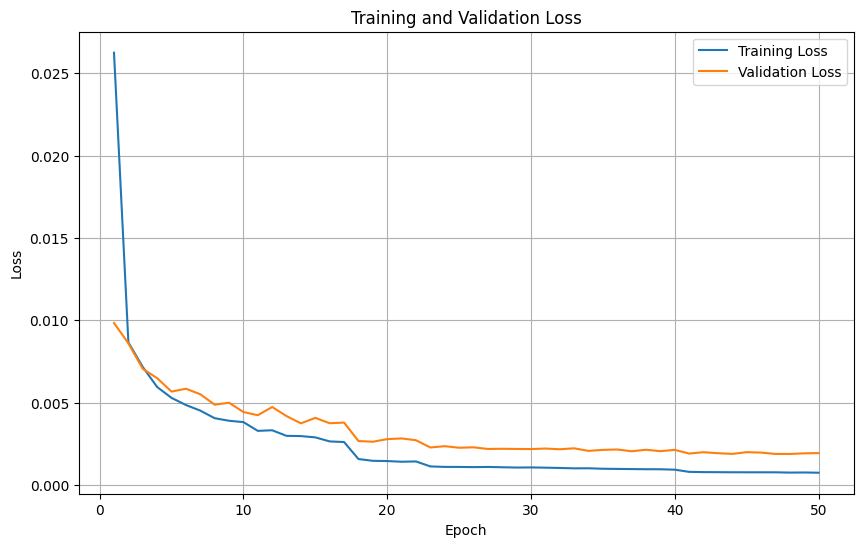

Evaluating on test set...


Evaluating on test set:   0%|          | 0/47 [00:00<?, ?it/s]


Test Evaluation Results:
  Average test loss: 0.001950
  Overall voxel accuracy: 0.9993
  Non-empty voxel accuracy: 0.8722
  Correct 3-object identification: 0.7080 (1062/1500)
Testing specific examples...

Testing: The car is to the right of the chair. The chair is above the lamp.
Predicted objects:
  Neural probe predicted: {'lamp': (4, 4, 2), 'chair': (4, 4, 4), 'car': (6, 4, 4)}
  Rule-based parser: {'lamp': (4, 4, 2), 'chair': (4, 4, 4), 'car': (6, 4, 4)}


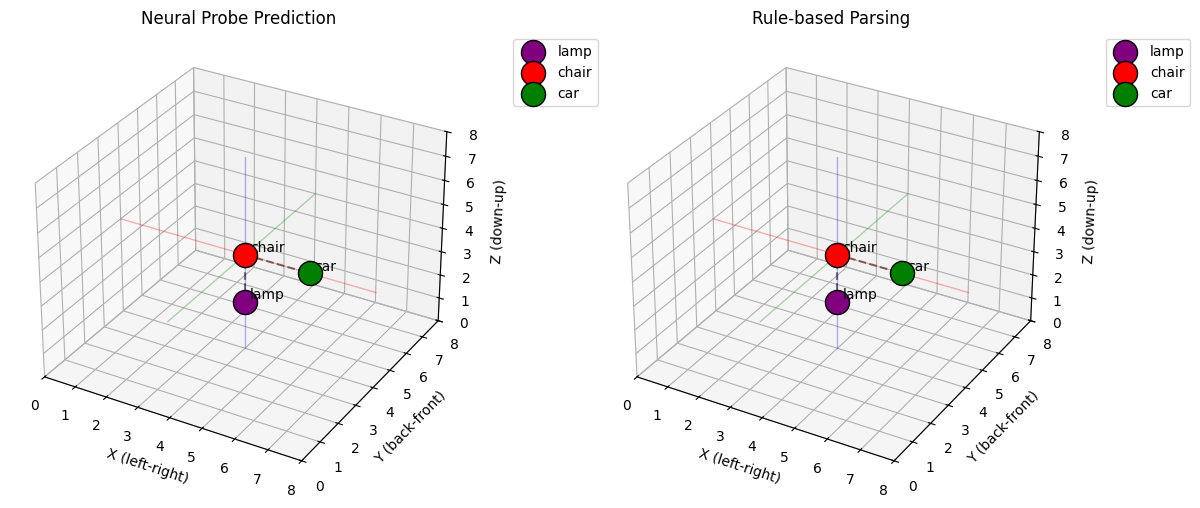


Testing: The box is above the table. The table is behind the chair.
Predicted objects:
  Neural probe predicted: {'table': (4, 4, 4), 'chair': (4, 4, 6)}
  Rule-based parser: {'table': (4, 4, 4), 'chair': (4, 6, 4), 'box': (4, 4, 6)}


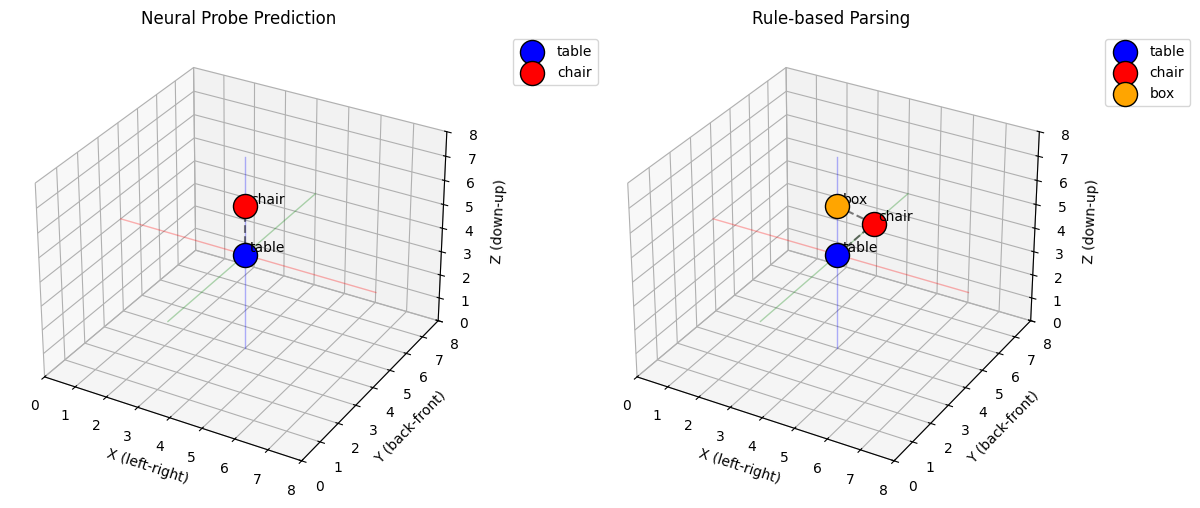


Testing: The lamp is below the vase. The vase is to the left of the book.
Predicted objects:
  Neural probe predicted: {'book': (4, 4, 6), 'vase': (4, 4, 4)}
  Rule-based parser: {'lamp': (4, 4, 2), 'vase': (4, 4, 4), 'book': (6, 4, 4)}


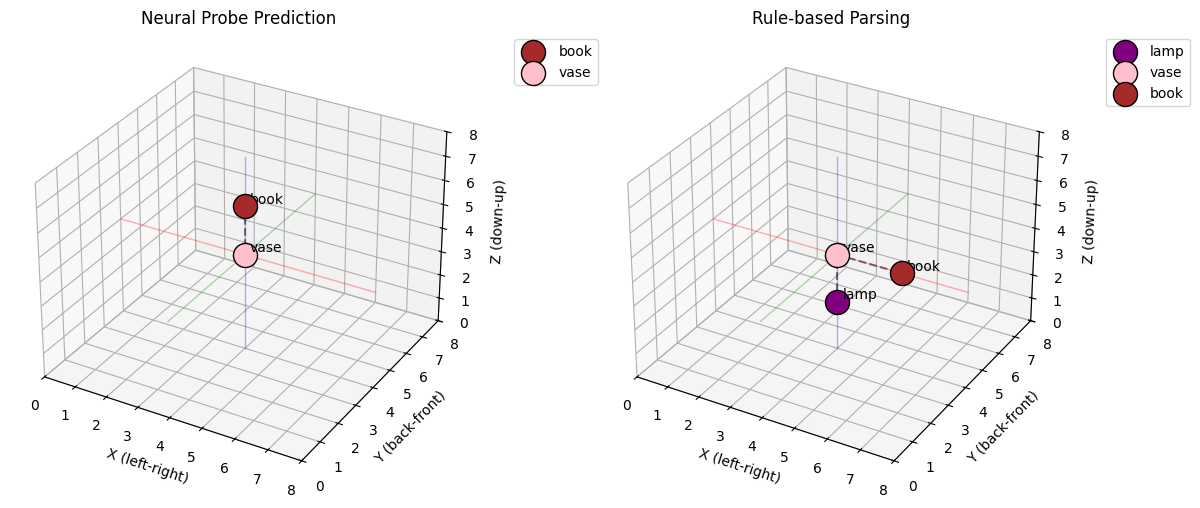


Testing: The plant is in front of the phone. The phone is above the computer.
Predicted objects:
  Neural probe predicted: {'computer': (4, 2, 4), 'phone': (4, 4, 4)}
  Rule-based parser: {'computer': (4, 4, 2), 'phone': (4, 4, 4), 'plant': (4, 6, 4)}


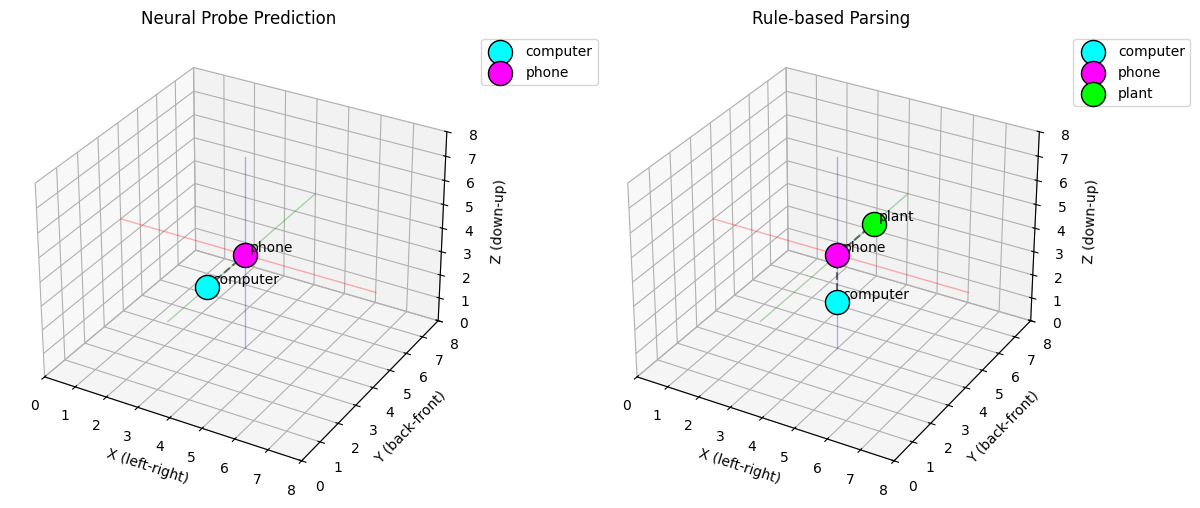


Testing: The book is diagonally front-left of the chair. The chair is behind the table.
Predicted objects:
  Neural probe predicted: {'chair': (4, 4, 4), 'book': (2, 6, 4), 'table': (4, 6, 4)}
  Rule-based parser: {'chair': (4, 4, 4), 'book': (2, 6, 4), 'table': (4, 6, 4)}


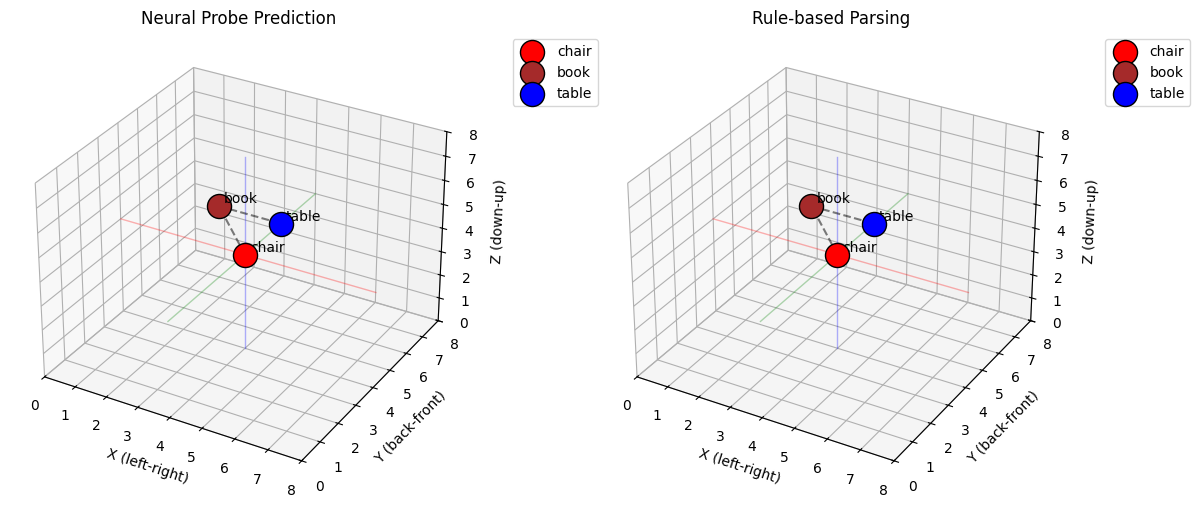


Testing: The chair is to the left of the box. The box is to the left of the lamp.
Predicted objects:
  Neural probe predicted: {'chair': (2, 4, 4), 'box': (4, 4, 4), 'lamp': (6, 4, 4)}
  Rule-based parser: {'chair': (2, 4, 4), 'box': (4, 4, 4), 'lamp': (6, 4, 4)}


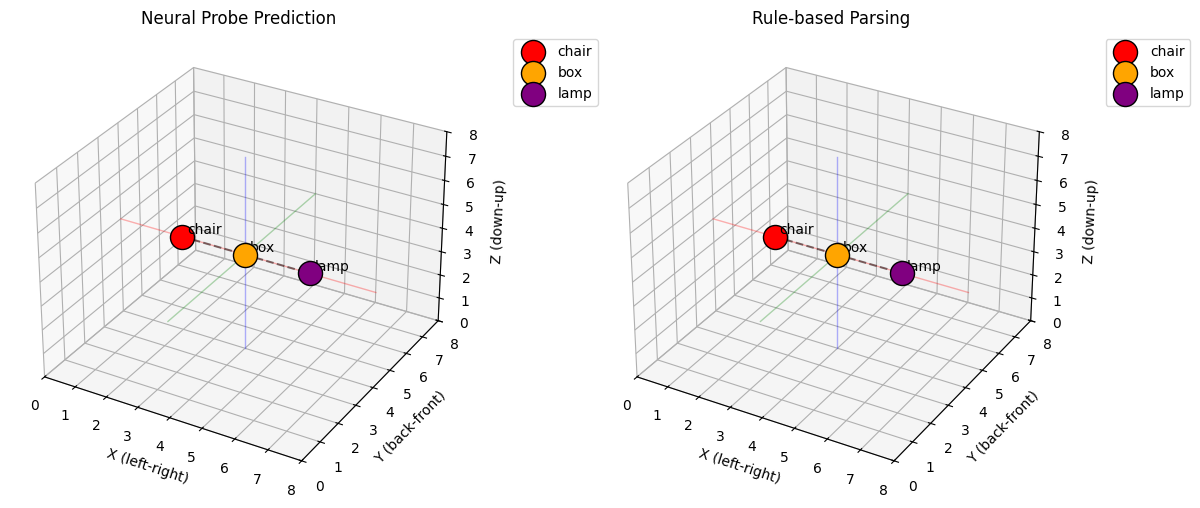

Model saved to three_object_probe.pt


In [2]:
if __name__ == "__main__":
    # You can provide your Hugging Face token here if needed
    # For example, from environment variables or other secure methods
    from google.colab import userdata
    hf_token = userdata.get('HF_Meta')

    # Run the main function
    probe, history, results = main_three_object_probe(hf_token)

In [6]:
probe

LinearSpatialProbe(
  (linear): Linear(in_features=3072, out_features=8019, bias=True)
)

## save

In [15]:
!cp three_object_probe.pt /content/drive/MyDrive/LLM_spatial_model_results/three_object_probe_10000.pt

# load and test the probe

In [9]:
def test_probe_examples(probe, num_examples=20):
    """Test the probe on specific examples and report accuracy."""
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import random
    import itertools
    import re
    from collections import Counter

    # First, load the model
    print("Loading LLM model...")
    MODEL_NAME = "meta-llama/Llama-3.2-3B"
    from os import environ
    hf_token = environ.get('HF_TOKEN', None)

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=hf_token)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                                output_hidden_states=True,
                                                token=hf_token).cuda()
    model.eval()
    tokenizer.pad_token = tokenizer.eos_token

    # Create test sentences
    test_sentences = [
        "The car is to the right of the chair. The chair is above the lamp.",
        "The box is above the table. The table is behind the chair.",
        "The lamp is below the vase. The vase is to the left of the book.",
        "The plant is in front of the phone. The phone is above the computer.",
        "The book is diagonally front-left of the chair. The chair is behind the table.",
        "The chair is to the left of the box. The box is to the left of the lamp."
    ]

    # Generate additional random examples if needed
    if num_examples > len(test_sentences):
        for _ in range(num_examples - len(test_sentences)):
            obj_a, obj_b, obj_c = random.sample(list(OBJECTS.keys()), 3)

            # Choose random relations
            relations = ["to the left of", "to the right of", "above", "below",
                        "in front of", "behind", "diagonally front-left of",
                        "diagonally front-right of"]
            rel1 = random.choice(relations)
            rel2 = random.choice(relations)

            # Create sentence
            sentence = f"The {obj_a} is {rel1} the {obj_b}. The {obj_b} is {rel2} the {obj_c}."
            test_sentences.append(sentence)

    # Trim to desired number
    test_sentences = test_sentences[:num_examples]

    # Function to get activations
    def get_last_token_activation(text):
        tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"].cuda()
        with torch.no_grad():
            outputs = model(tokens, output_hidden_states=True)
        last_token_idx = tokens.shape[1] - 1
        last_token_activation = outputs.hidden_states[-1][:, last_token_idx, :]
        return last_token_activation.squeeze(0)

    # Function to parse sentences
    def parse_three_object_sentence(sentence, grid_size=(9, 9, 9)):
        """Parse a 3-object sentence into a 3D grid representation."""
        grid = np.zeros(grid_size, dtype=int)
        center = (grid_size[0]//2, grid_size[1]//2, grid_size[2]//2)

        # Split into two parts
        parts = sentence.split('.')
        if len(parts) < 2:
            return grid  # Not enough parts

        # Extract the two relationships
        relations = []
        objects = []

        for part in parts:
            if not part.strip():
                continue

            pattern = r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)"
            matches = re.findall(pattern, part, re.IGNORECASE)

            if matches:
                obj1, relation, obj2 = matches[0]
                norm_relation = normalize_relation(relation)
                relations.append(norm_relation)

                if obj1 not in objects:
                    objects.append(obj1)
                if obj2 not in objects:
                    objects.append(obj2)

        # We need exactly 3 objects and 2 relations for a valid 3-object setup
        if len(objects) != 3 or len(relations) != 2:
            return grid

        # Determine the middle object (appears in both relationships)
        object_counts = Counter(re.findall(r'the (\w+)', sentence.lower()))
        middle_object = max(objects, key=lambda obj: object_counts[obj.lower()])

        # Place middle object at center
        middle_idx = objects.index(middle_object)
        middle_pos = center

        # Place the other two objects based on their relationships to the middle object
        positions = {middle_object: middle_pos}

        # Process first relationship
        pattern1 = r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)"
        matches1 = re.findall(pattern1, parts[0], re.IGNORECASE)

        if matches1:
            obj1, relation, obj2 = matches1[0]
            norm_relation = normalize_relation(relation)

            # If obj2 is the middle object, place obj1 relative to it
            if obj2 == middle_object and norm_relation in SPATIAL_MAP:
                dx, dy, dz = SPATIAL_MAP[norm_relation]
                x2, y2, z2 = positions[middle_object]
                x1 = max(0, min(x2 + dx, grid_size[0]-1))
                y1 = max(0, min(y2 + dy, grid_size[1]-1))
                z1 = max(0, min(z2 + dz, grid_size[2]-1))
                positions[obj1] = (x1, y1, z1)

            # If obj1 is the middle object, place obj2 relative to it
            elif obj1 == middle_object and norm_relation in SPATIAL_MAP:
                dx, dy, dz = SPATIAL_MAP[norm_relation]
                x1, y1, z1 = positions[middle_object]
                x2 = max(0, min(x1 - dx, grid_size[0]-1))  # Invert direction
                y2 = max(0, min(y1 - dy, grid_size[1]-1))  # Invert direction
                z2 = max(0, min(z1 - dz, grid_size[2]-1))  # Invert direction
                positions[obj2] = (x2, y2, z2)

        # Process second relationship
        pattern2 = r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)"
        matches2 = re.findall(pattern2, parts[1], re.IGNORECASE)

        if matches2:
            obj1, relation, obj2 = matches2[0]
            norm_relation = normalize_relation(relation)

            # If obj2 is the middle object, place obj1 relative to it
            if obj2 == middle_object and norm_relation in SPATIAL_MAP:
                dx, dy, dz = SPATIAL_MAP[norm_relation]
                x2, y2, z2 = positions[middle_object]
                x1 = max(0, min(x2 + dx, grid_size[0]-1))
                y1 = max(0, min(y2 + dy, grid_size[1]-1))
                z1 = max(0, min(z2 + dz, grid_size[2]-1))
                positions[obj1] = (x1, y1, z1)

            # If obj1 is the middle object, place obj2 relative to it
            elif obj1 == middle_object and norm_relation in SPATIAL_MAP:
                dx, dy, dz = SPATIAL_MAP[norm_relation]
                x1, y1, z1 = positions[middle_object]
                x2 = max(0, min(x1 - dx, grid_size[0]-1))  # Invert direction
                y2 = max(0, min(y1 - dy, grid_size[1]-1))  # Invert direction
                z2 = max(0, min(z1 - dz, grid_size[2]-1))  # Invert direction
                positions[obj2] = (x2, y2, z2)

        # Place objects in grid
        for obj_name, pos in positions.items():
            if obj_name in OBJECTS:
                x, y, z = pos
                grid[z, y, x] = OBJECTS[obj_name]

        return grid

    # Function to visualize grid
    def visualize_grid(grid, ax=None, title="3D Spatial relationship"):
        if ax is None:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

        # Find objects in the grid
        object_positions = {}
        for z in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                for x in range(grid.shape[2]):
                    obj_id = grid[z, y, x]
                    if obj_id > 0:
                        obj_name = list(OBJECTS.keys())[list(OBJECTS.values()).index(obj_id)]
                        object_positions[obj_name] = (x, y, z)

        # Define colors for different objects
        colors = {
            'chair': 'red', 'table': 'blue', 'car': 'green', 'lamp': 'purple',
            'box': 'orange', 'book': 'brown', 'vase': 'pink',
            'plant': 'lime', 'computer': 'cyan', 'phone': 'magenta'
        }

        # Draw coordinate axes
        center = (grid.shape[2]//2, grid.shape[1]//2, grid.shape[0]//2)
        ax.plot([0, grid.shape[2]-1], [center[1], center[1]], [center[2], center[2]],
                'r-', linewidth=1, alpha=0.3)
        ax.plot([center[0], center[0]], [0, grid.shape[1]-1], [center[2], center[2]],
                'g-', linewidth=1, alpha=0.3)
        ax.plot([center[0], center[0]], [center[1], center[1]], [0, grid.shape[0]-1],
                'b-', linewidth=1, alpha=0.3)

        # Draw objects
        for obj_name, (x, y, z) in object_positions.items():
            ax.scatter(x, y, z, color=colors.get(obj_name, 'gray'),
                      s=300, label=obj_name, edgecolors='black')
            ax.text(x+0.1, y+0.1, z+0.1, obj_name, fontsize=10)

        # Draw lines between objects if there are multiple
        if len(object_positions) > 1:
            # Get position list
            positions = list(object_positions.values())
            obj_names = list(object_positions.keys())

            # Draw lines connecting objects
            for i in range(len(positions)-1):
                ax.plot([positions[i][0], positions[i+1][0]],
                       [positions[i][1], positions[i+1][1]],
                       [positions[i][2], positions[i+1][2]],
                       'k--', alpha=0.5)

        # Set axis labels and limits
        ax.set_xlabel('X (left-right)')
        ax.set_ylabel('Y (back-front)')
        ax.set_zlabel('Z (down-up)')

        # Set axis limits
        ax.set_xlim(0, grid.shape[2]-1)
        ax.set_ylim(0, grid.shape[1]-1)
        ax.set_zlim(0, grid.shape[0]-1)

        # Add legend and only show unique entries
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if by_label:
            ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        # Add title
        ax.set_title(title)

        return ax

    # Track results
    correct_count = 0

    # Test each sentence
    for i, sentence in enumerate(test_sentences):
        print(f"\nTest {i+1}: {sentence}")

        # Get activation and predict grid
        activation = get_last_token_activation(sentence).unsqueeze(0).cuda()
        predictions = probe(activation)
        predicted_grid = predictions[0].argmax(dim=0).cpu().numpy()

        # Parse with rule-based method for comparison
        parsed_grid = parse_three_object_sentence(sentence)

        # Extract objects from predicted and parsed grids
        pred_objects = {}
        parse_objects = {}

        for z in range(predicted_grid.shape[0]):
            for y in range(predicted_grid.shape[1]):
                for x in range(predicted_grid.shape[2]):
                    if predicted_grid[z, y, x] > 0:
                        obj_id = predicted_grid[z, y, x]
                        if obj_id <= len(list(OBJECTS.keys())):
                            obj_name = list(OBJECTS.keys())[list(OBJECTS.values()).index(obj_id)]
                            pred_objects[obj_name] = (x, y, z)

                    if parsed_grid[z, y, x] > 0:
                        obj_id = parsed_grid[z, y, x]
                        if obj_id <= len(list(OBJECTS.keys())):
                            obj_name = list(OBJECTS.keys())[list(OBJECTS.values()).index(obj_id)]
                            parse_objects[obj_name] = (x, y, z)

        # Check if objects and relationships are correct
        objects_correct = set(pred_objects.keys()) == set(parse_objects.keys())

        # Check spatial relationships
        relationships_correct = True
        if objects_correct and len(pred_objects) >= 2:
            for obj1, obj2 in itertools.combinations(pred_objects.keys(), 2):
                # Calculate direction vectors
                pred_vec = (pred_objects[obj2][0] - pred_objects[obj1][0],
                           pred_objects[obj2][1] - pred_objects[obj1][1],
                           pred_objects[obj2][2] - pred_objects[obj1][2])

                parse_vec = (parse_objects[obj2][0] - parse_objects[obj1][0],
                            parse_objects[obj2][1] - parse_objects[obj1][1],
                            parse_objects[obj2][2] - parse_objects[obj1][2])

                # Check if directions match
                if (np.sign(pred_vec[0]) != np.sign(parse_vec[0]) or
                    np.sign(pred_vec[1]) != np.sign(parse_vec[1]) or
                    np.sign(pred_vec[2]) != np.sign(parse_vec[2])):
                    relationships_correct = False
                    break
        else:
            relationships_correct = False

        # Print results
        print(f"  Objects identified correctly: {'✓' if objects_correct else '✗'}")
        print(f"  Spatial relationships preserved: {'✓' if relationships_correct else '✗'}")

        # Count correct examples
        if relationships_correct:
            correct_count += 1

        # Visualize comparison
        fig = plt.figure(figsize=(12, 6))

        # Neural probe prediction
        ax1 = fig.add_subplot(121, projection='3d')
        visualize_grid(predicted_grid, ax1, title="Neural Probe Prediction")

        # Rule-based parser results
        ax2 = fig.add_subplot(122, projection='3d')
        visualize_grid(parsed_grid, ax2, title="Rule-based Parsing")

        plt.tight_layout()
        plt.show()

    # Report overall accuracy
    accuracy = correct_count / len(test_sentences) * 100
    print(f"\nOverall accuracy: {correct_count}/{len(test_sentences)} correct ({accuracy:.1f}%)")

    return correct_count, len(test_sentences), accuracy

Loading LLM model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Test 1: The car is to the right of the chair. The chair is above the lamp.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


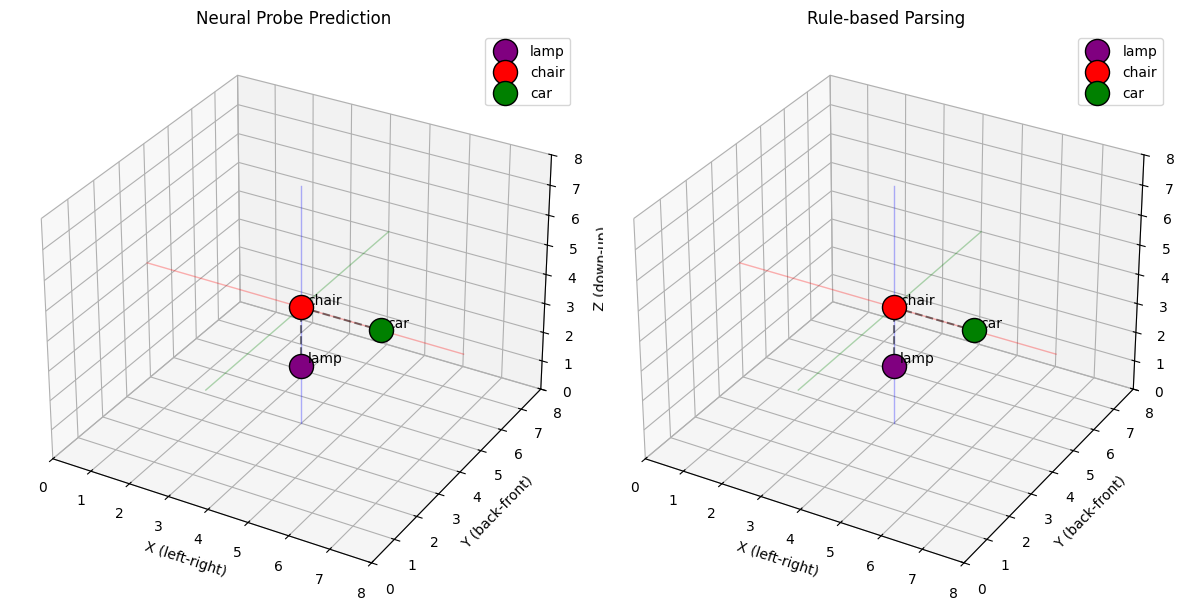


Test 2: The box is above the table. The table is behind the chair.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


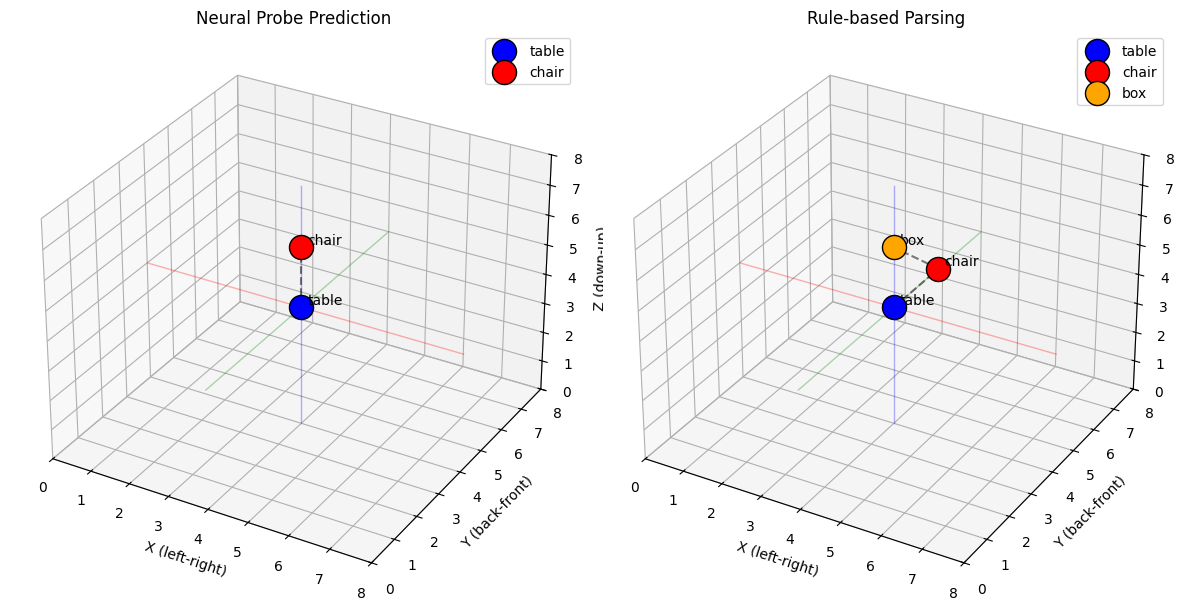


Test 3: The lamp is below the vase. The vase is to the left of the book.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


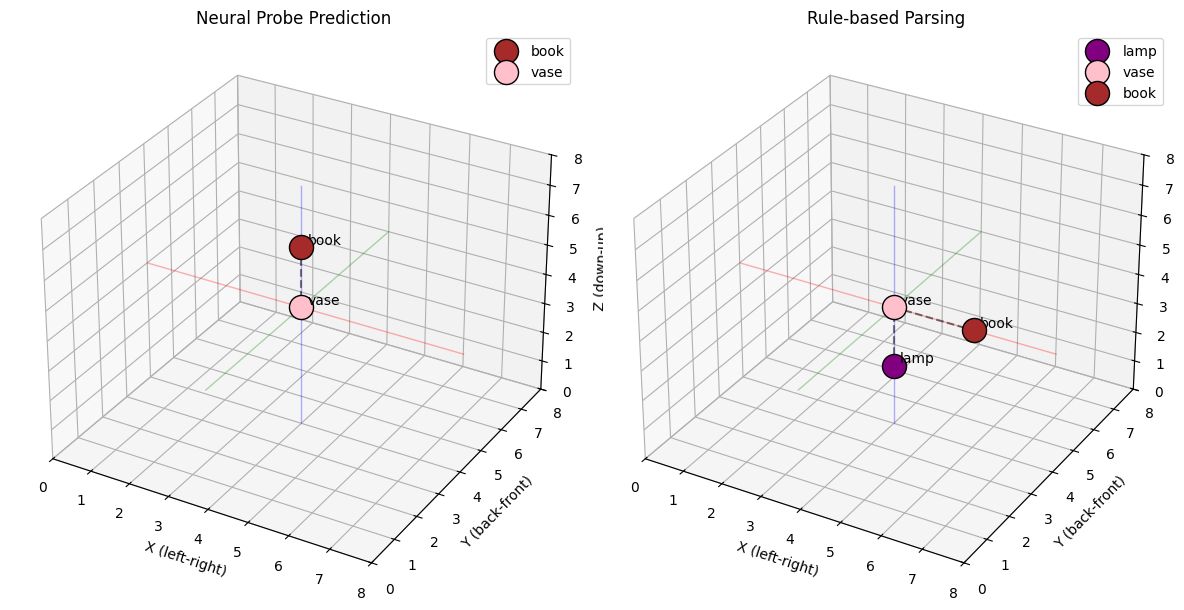


Test 4: The plant is in front of the phone. The phone is above the computer.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


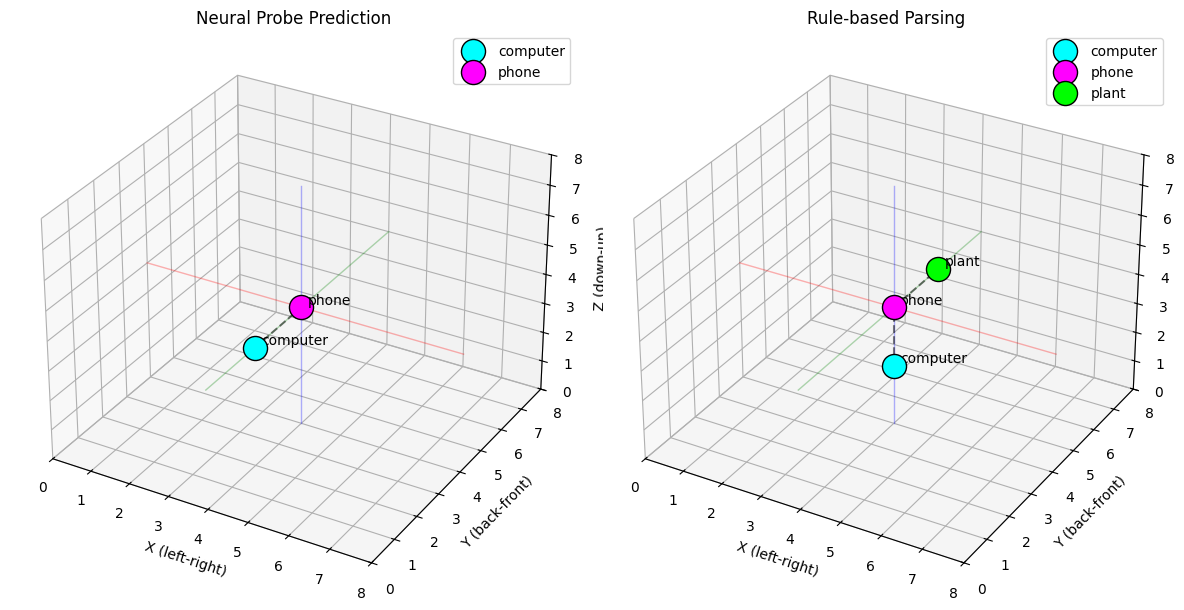


Test 5: The book is diagonally front-left of the chair. The chair is behind the table.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


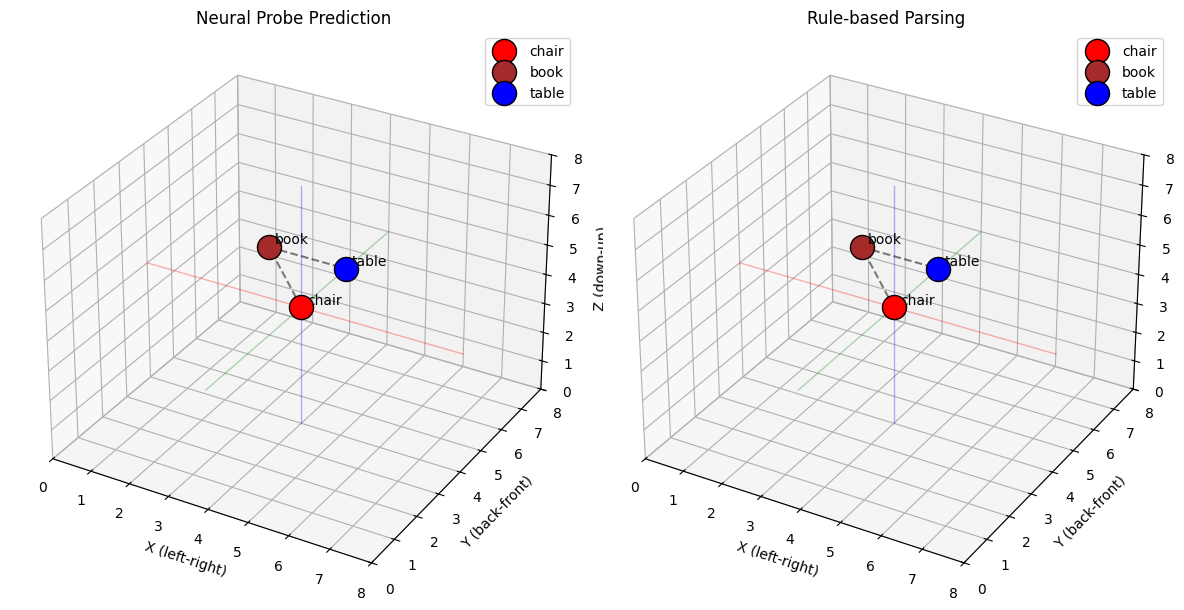


Test 6: The chair is to the left of the box. The box is to the left of the lamp.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


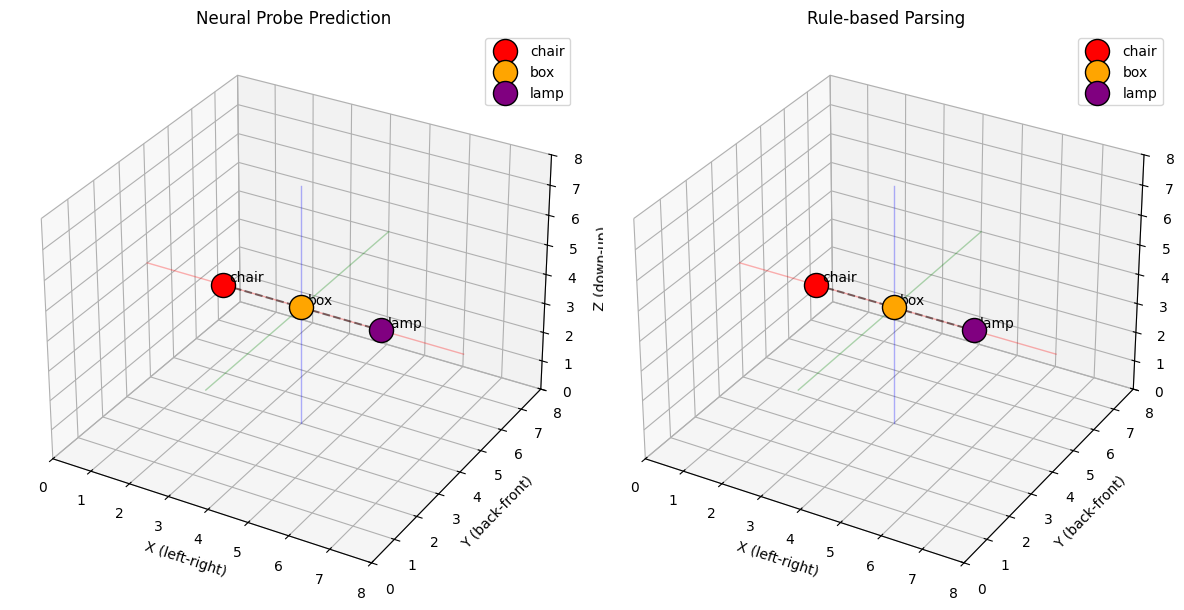


Test 7: The table is above the lamp. The lamp is to the right of the book.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


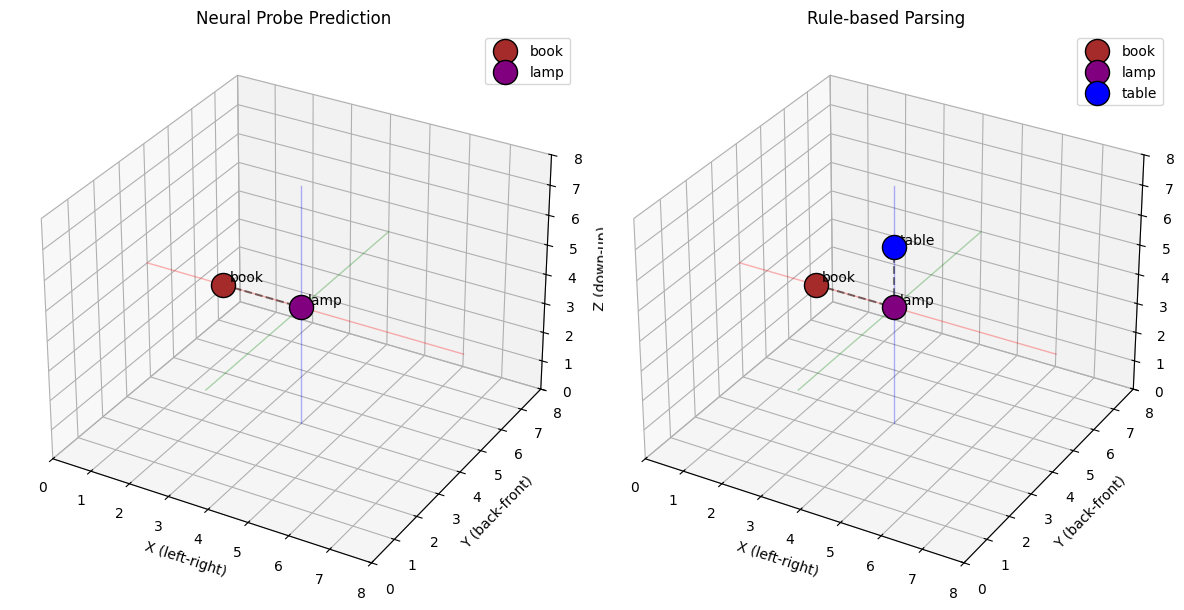


Test 8: The chair is to the right of the vase. The vase is diagonally front-left of the computer.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


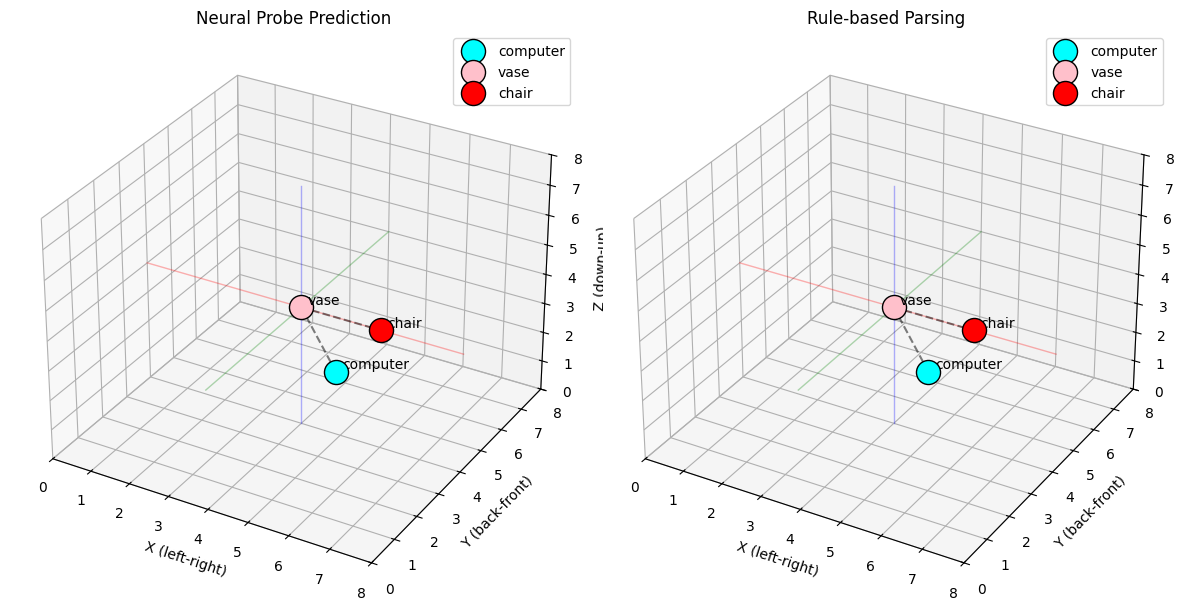


Test 9: The chair is above the lamp. The lamp is to the left of the vase.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


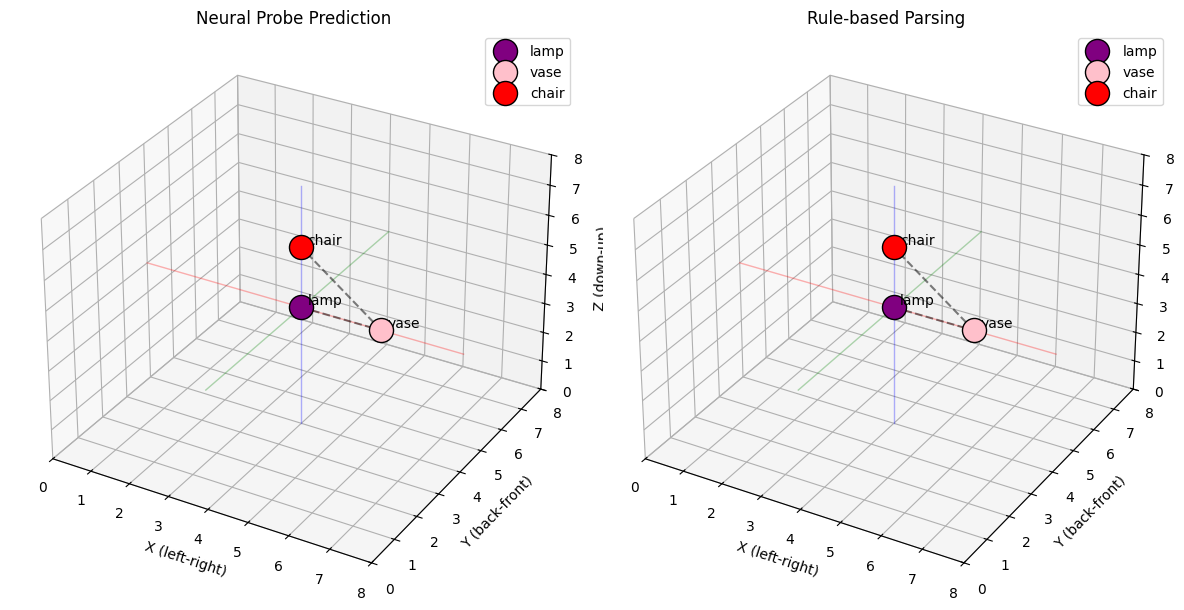


Test 10: The lamp is in front of the plant. The plant is diagonally front-right of the computer.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


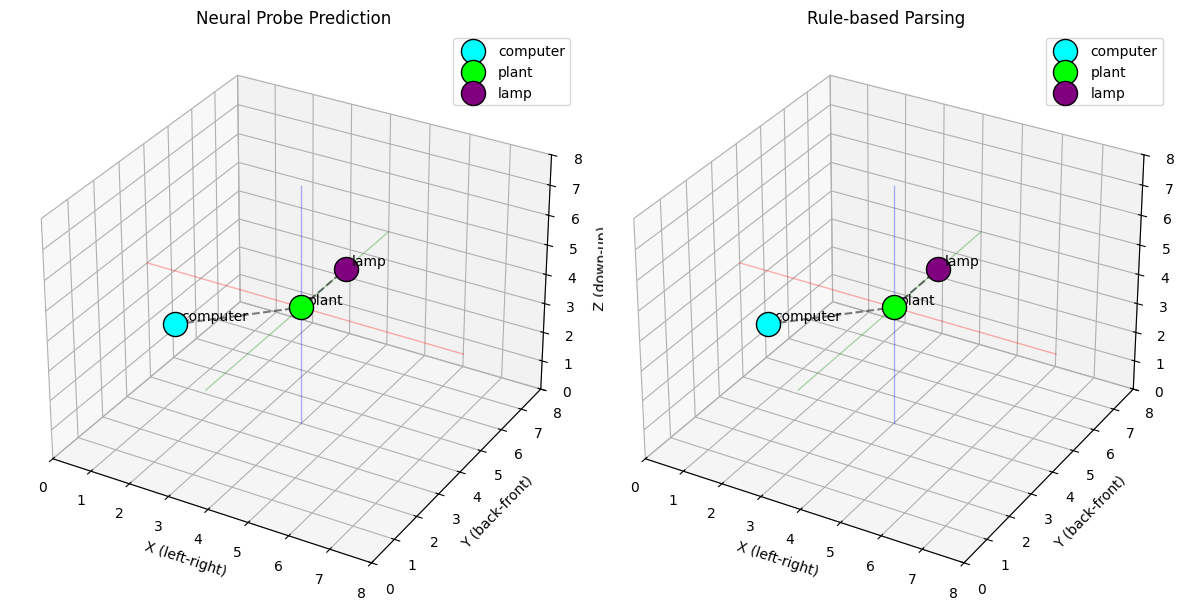


Test 11: The chair is diagonally front-left of the lamp. The lamp is to the left of the table.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


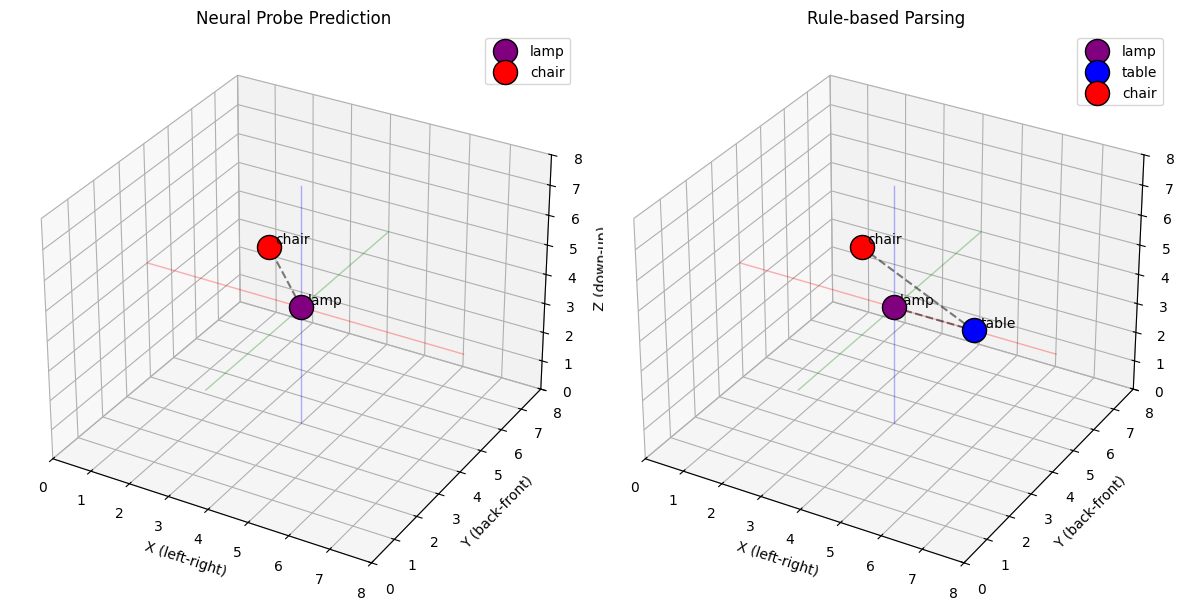


Test 12: The phone is to the right of the car. The car is diagonally front-right of the lamp.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


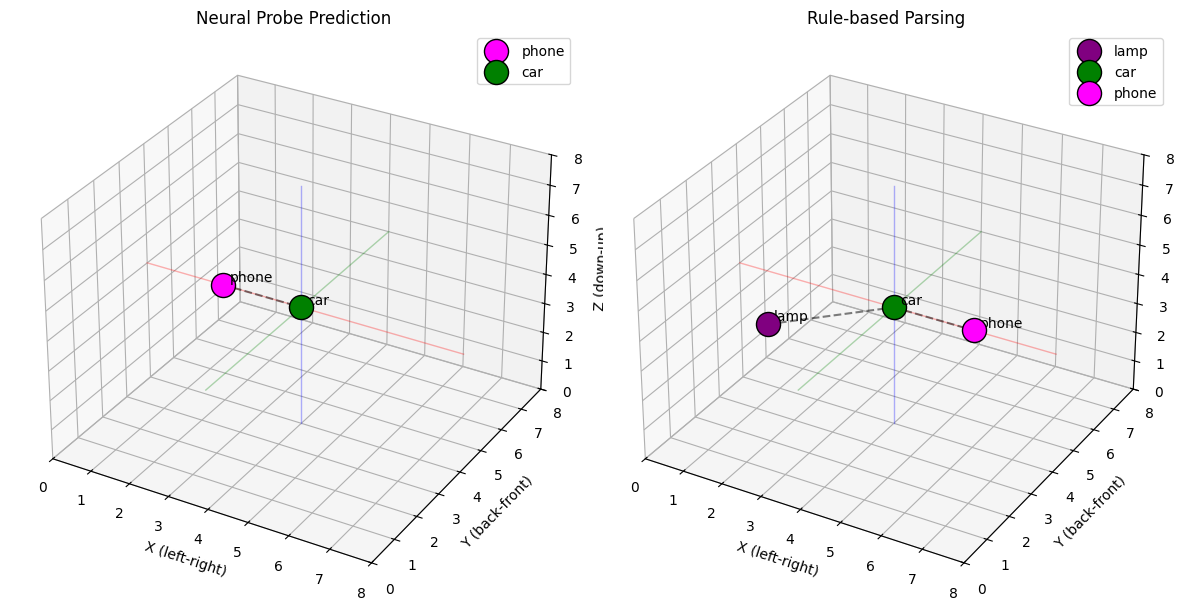


Test 13: The vase is above the table. The table is above the box.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


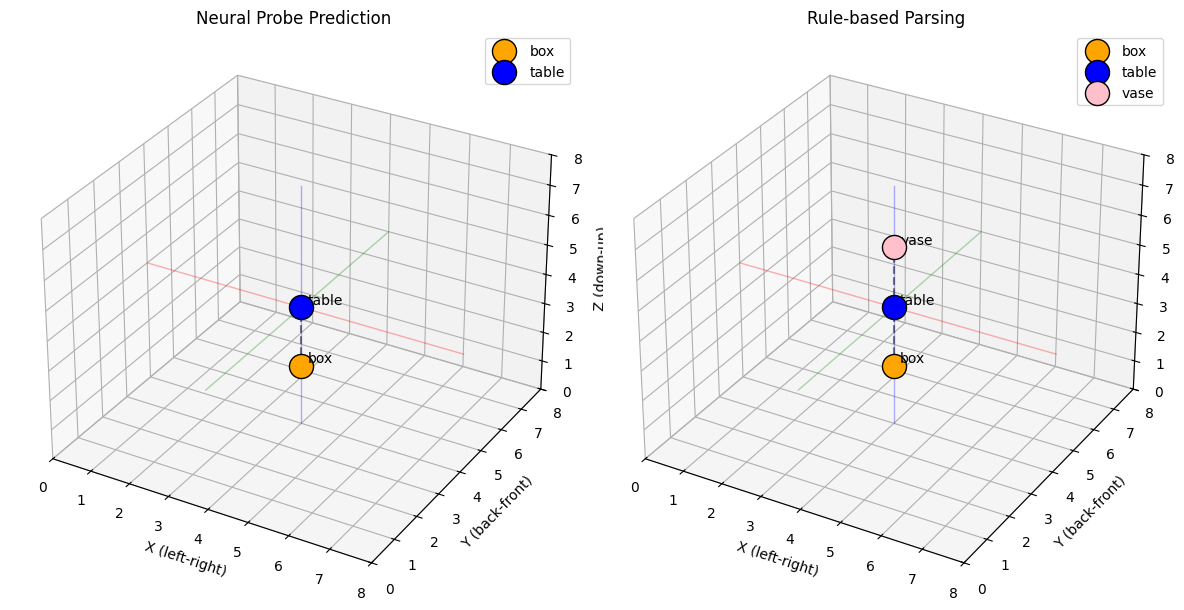


Test 14: The lamp is to the left of the computer. The computer is above the book.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


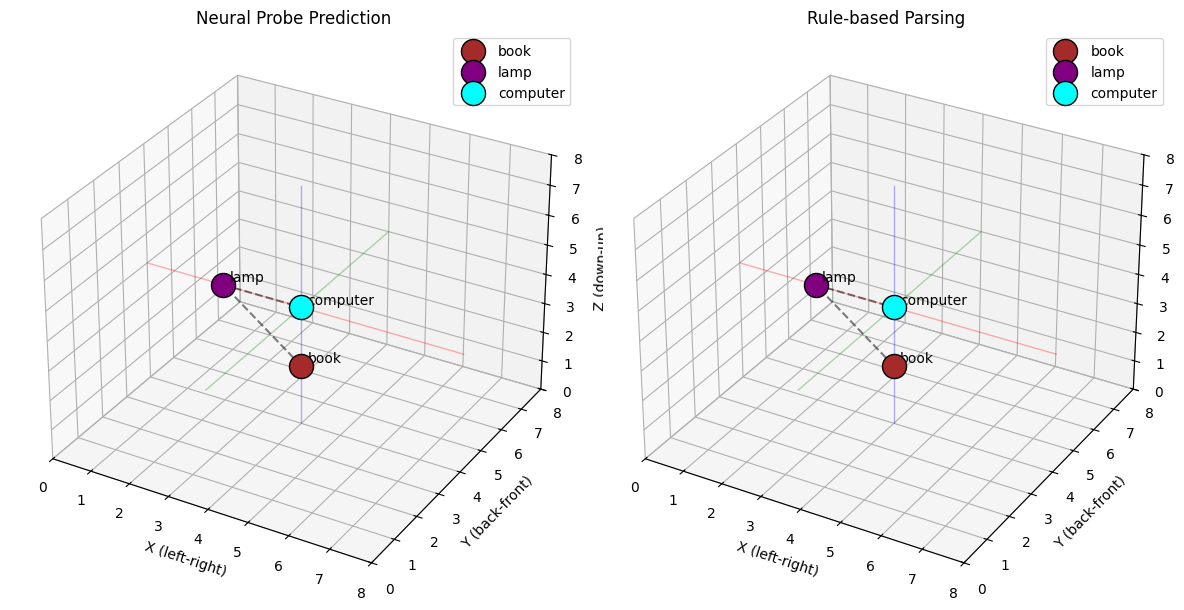


Test 15: The plant is to the left of the table. The table is diagonally front-right of the phone.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


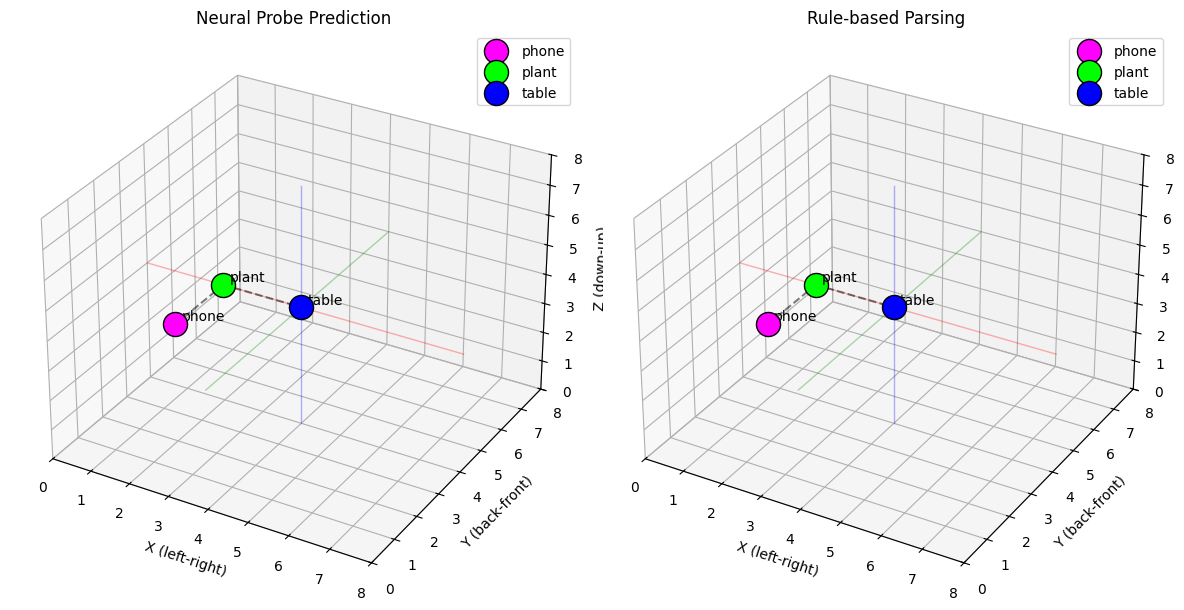


Test 16: The table is diagonally front-right of the book. The book is below the car.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


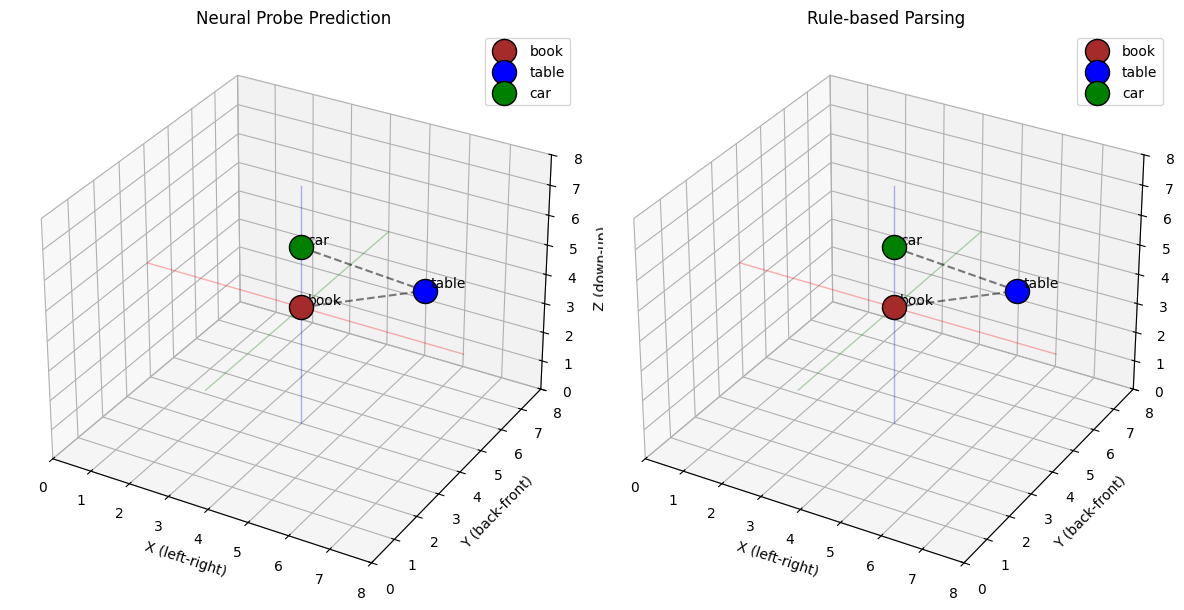


Test 17: The lamp is above the plant. The plant is diagonally front-left of the vase.
  Objects identified correctly: ✗
  Spatial relationships preserved: ✗


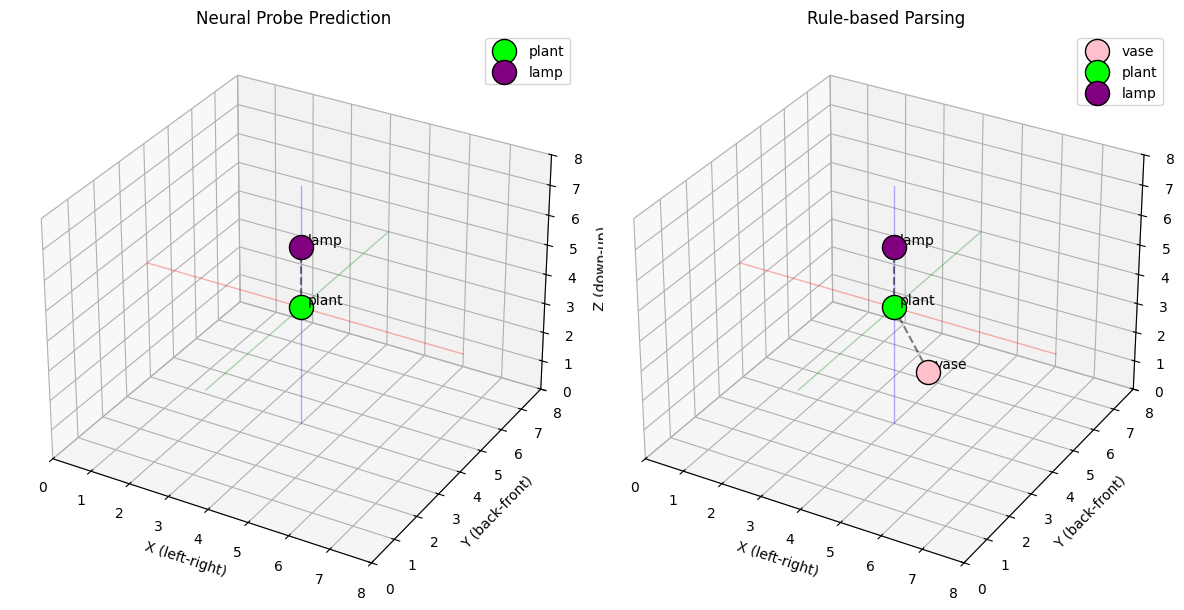


Test 18: The book is above the vase. The vase is behind the box.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✗


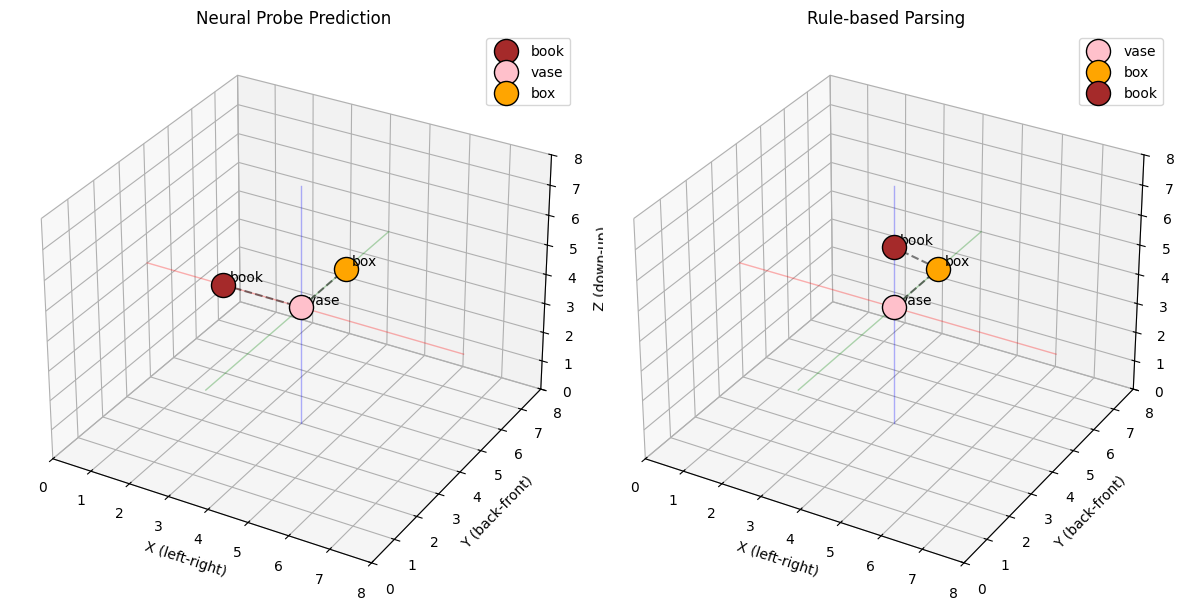


Test 19: The book is to the right of the plant. The plant is behind the lamp.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


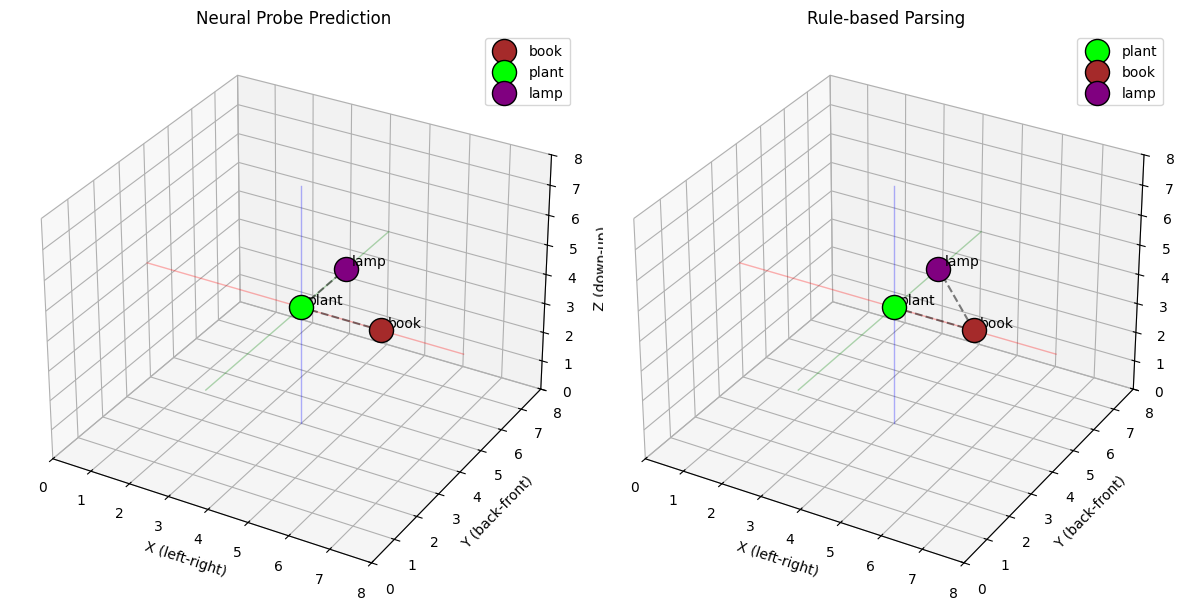


Test 20: The car is above the phone. The phone is to the left of the book.
  Objects identified correctly: ✓
  Spatial relationships preserved: ✓


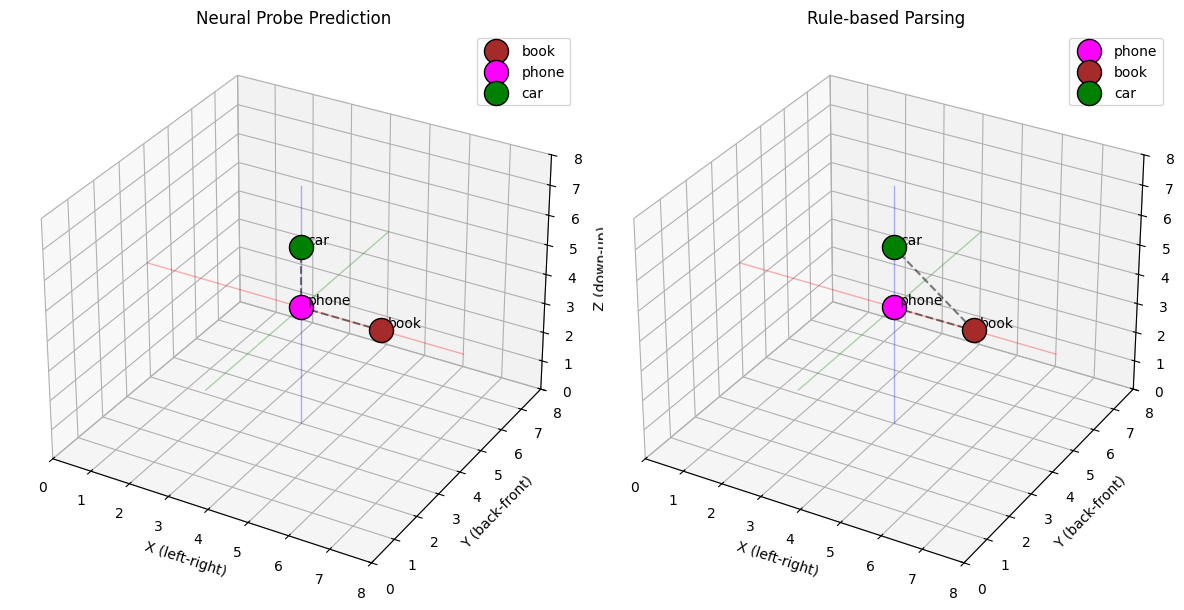


Overall accuracy: 11/20 correct (55.0%)


In [13]:
correct, total, accuracy = test_probe_examples(probe, num_examples=20)

# end